# Imports and set up

In [1]:
!pip install -U nltk
!pip install spellchecker
!pip install pyspellchecker
import nltk; nltk.download('popular')
import pandas as pd
from google.colab import drive
import string
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
from collections import Counter
from os import listdir
from keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
drive.mount('/content/drive')
import ipywidgets as widgets
from IPython.display import clear_output
clear_output()

# Task 1

## Clean data for vocab

The following code block processes the data for the vocabulary which is used for the models such as LSI. This is done first by reading the data as a data frame, extracts the reviews and then cleans the data using various tcehniques. These include: splitting by words , making all the tokens lowercase, removing punctuation, converting numbers to words i.e. '2' to 'two', removing stop words, removing short words, applying a spell corrector to re-spell misspelled words and then applied a lementizer to reduce the words to their root form. In addition, the icon ':)' was used a lot in the data however, instead of removing it, this was converted to the word 'happy'.

In [2]:
import inflect
from spellchecker import SpellChecker
from nltk.stem import PorterStemmer, WordNetLemmatizer

def clean_data(txt):
    # split into tokens by white space
    tokens = txt.split()

    # convert :) to the word happy

    if ':)' in tokens:
        tokens[tokens.index(':)')] = 'happy'

    # convert each word to lowercase
    tokens = [word.lower() for word in tokens]

    # remove punctuation from each token
    table = str.maketrans('', '', string.punctuation)
    tokens = [w.translate(table) for w in tokens]

    # remove remaining tokens that are not alphabetic or numeric
    tokens = [word for word in tokens if word.isalpha() or word.isnumeric()]

    # convert numeric tokens to words
    p = inflect.engine()
    tokens = [p.number_to_words(word) if word.isnumeric() else word for word in tokens]

    # remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]

    # remove short tokens
    tokens = [word for word in tokens if len(word) > 1]

    # Perform spelling correction and filter out None values
    spell = SpellChecker()
    tokens = [spell.correction(word) for word in tokens if spell.correction(word) is not None]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]


    return tokens


def process_data(dataPath):
    df = pd.read_csv(dataPath)

    # get rid of duplicated rows
    df = df.drop_duplicates()

    # extract reviews
    ratings = df['Reviews']

    data = []
    # loop through the data, clean it and discard repeated data
    unique_lines_set = set()
    for line in ratings:
        if line not in unique_lines_set:
            cleaned_line = clean_data(line)
            data.append(cleaned_line)
            unique_lines_set.add(line)
            #print(cleaned_line)

    return data


# read data path
file1 = "/content/drive/MyDrive/Colab Notebooks/COP509cw/Datasets/JewelleryReviewsLSA.csv"

data = process_data(file1)

## Vocab

Next, a vocab was created by counting the occurance of words and then it filterring the vocabulary to only keep tokens with a minimum occurrence threshold of 2.

In [10]:
all_words=[]
for word_list in data:
  for word in word_list:
    all_words.append(word)
print(len(all_words))
vocab = Counter()
vocab.update(all_words)
print(vocab.most_common(40))

3259
[('ring', 333), ('look', 69), ('like', 56), ('wear', 47), ('picture', 44), ('one', 39), ('love', 38), ('quality', 37), ('item', 36), ('beautiful', 31), ('would', 28), ('great', 25), ('nice', 24), ('bought', 20), ('stone', 19), ('bracelet', 19), ('gift', 18), ('diamond', 17), ('got', 17), ('silver', 17), ('small', 17), ('pretty', 17), ('color', 17), ('size', 16), ('time', 16), ('received', 16), ('price', 15), ('buy', 15), ('perfect', 15), ('recommend', 14), ('fit', 14), ("don't", 13), ('definitely', 13), ('wearing', 13), ('product', 13), ('looking', 13), ('little', 12), ('much', 12), ('also', 12), ('looked', 12)]


In [11]:
# keep tokens with a min occurrence
min_occurane = 2
tokens = [k for k,c in vocab.items() if c >= min_occurane]
print(len(tokens))
vocab = set(tokens)
print(vocab)

433
{'believe', 'nothing', 'though', 'tongue', 'addiction', 'pick', 'solid', 'picture', 'princess', 'similar', 'stack', 'way', 'taste', 'receiving', 'description', 'dainty', 'necklace', 'recommend', 'week', 'always', 'purchase', 'suit', 'black', 'ring', 'joint', 'wedding', 'easily', 'right', 'wearing', 'purchased', 'sure', 'really', 'promptly', 'avenue', 'easy', 'casual', 'company', 'design', 'thing', 'quickly', 'ten', 'shell', 'fit', 'exactly', 'big', 'pretty', 'condition', 'polished', 'toe', 'tried', 'appearance', 'yet', 'bracelet', 'seemed', 'pendant', 'clear', 'worried', 'attractive', 'loved', 'already', 'bulkier', 'jeweler', 'bead', "doesn't", 'excellent', 'lost', 'quality', 'date', 'harm', 'new', 'first', 'year', 'buying', 'lover', 'many', 'hoped', 'something', 'pink', 'aware', 'timely', 'opened', 'claddagh', 'may', 'light', 'showed', 'product', 'get', 'next', 'day', 'cross', 'white', 'totally', 'birthday', 'sturdy', 'add', 'fused', 'arrived', 'one', 'given', 'otherwise', 'thin',

## Clean data

Finally, the last part of the pre-processing was to clean the data for the models. Firstly, the data was read using a pandas data frame. Duplicate rows that were in the data were removed. The review data and associated id's were extracted and mapped using a dictionary so that this mapping could be used in the future for display purposes. Next, the data was cleaned the same way as before. In the data, it was noticed that there were duplicted reviews even though they had different ids. These duplicate reviews and ids were removed so that the remaining data and ids had no duplicates

In [12]:
file1 = '/content/drive/MyDrive/Colab Notebooks/COP509cw/Datasets/JewelleryReviewsLSA.csv'

# Read the CSV file into a DataFrame
df = pd.read_csv(file1)

# remove duplicates
newdf = df.drop_duplicates()

#ids column
ids = newdf['ID'].tolist()

# reviews column
data = newdf['Reviews'].tolist()

ratings = newdf['Ratings'].tolist()

# Mapping from id to raw data
id_to_raw_data = dict(zip(ids, data))

# Mapping from raw data to ratings

id_to_rating = dict(zip(data, ratings))

# Get unique lines and corresponding IDs
unique_data = []
unique_data_raw = []
unique_ids = []
unique_ratings = []

unique_lines_set = set()

# loop through data and remove duplicate ids and reviews
for line, id_value in zip(data, ids):
    if line not in unique_lines_set:
        clean = clean_data(line)
        cleaned_line = ' '.join(clean)
        unique_data.append(cleaned_line)
        unique_data_raw.append(line)
        unique_ids.append(id_value)
        unique_lines_set.add(line)

# mapping from clean data to id which could be used in future
id_to_clean_data = dict(zip(unique_ids, unique_data))

# mapping from clean data to raw data
clean_data_to_raw = dict(zip(unique_data, unique_data_raw))

ids = unique_ids
data = unique_data

# print to view cleaned data

#print(ids)
#print(data)
print(len(ids))
print(len(data))

184
184


Here is a word cloud to display the different words and relative importance for the data. Code source is show in comment below:

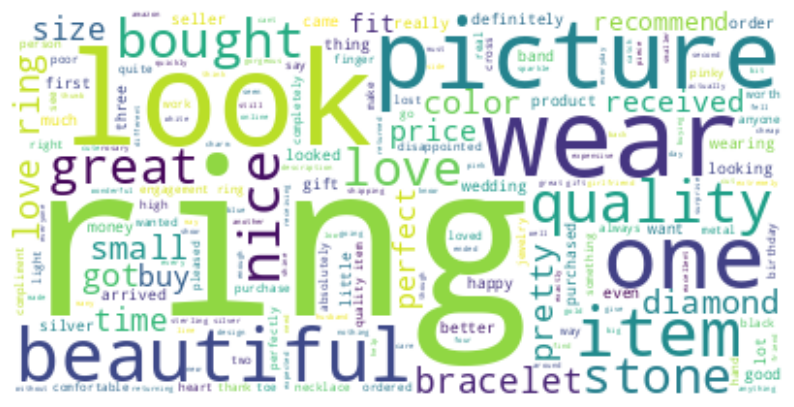

In [13]:
import matplotlib.pyplot as plt


# source: https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0

# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(data)
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word c

# Visualize the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Task 2 (LSI)

## 2a & 2C - Latent Semantic Indexing Model with Evaluation

The following code block uses a latent semantic indexing (LSI) model to retrieve the top 10 documents for 8 different queries.The data and queries are first transformed to a vectorized format using Tf-IDF. This algorithm represents the data in a high dimensional space and captures the importance of each term relative to the whole document. Then using Singular Value Decomposition (SVD), the data and query dimensions are reduced to the same dimenional space. The cosine similarity is then compared between the documents and the query. The 10 most similar docs are then retrieved. The precision, recall and f1 score is calculated by comparing the retrieved docs with the actual relevant docs. These evaluation methods were calculated across all queries and the average was calculated and presetnted with graphs

Query:1
Top n document IDs: [6522, 58481, 26246, 2033, 48779, 34523, 49525, 41876, 17309, 17273]
Actual relevant ids:[36164, 58481, 26246, 2033, 48779, 34523, 9726, 56494, 49525, 45278, 35694, 41876, 17309, 11135, 17273, 11247]
Relevant [0, 1, 1, 1, 1, 1, 1, 1, 1, 1]
precision: [0.0, 0.5, 0.6666666666666666, 0.75, 0.8, 0.8333333333333334, 0.8571428571428571, 0.875, 0.8888888888888888, 0.9]
Recall: [0.0, 0.0625, 0.125, 0.1875, 0.25, 0.3125, 0.375, 0.4375, 0.5, 0.5625]
F1 Score [0, 0.1111111111111111, 0.21052631578947367, 0.3, 0.38095238095238093, 0.45454545454545453, 0.5217391304347825, 0.5833333333333334, 0.64, 0.6923076923076923]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Query:2
Top n document IDs: [51907, 57123, 25299, 55017, 7432, 2114, 40871, 13373, 642, 56865]
Actual relevant ids:[57123, 25299, 55017, 7432, 2114, 40871]
Rele

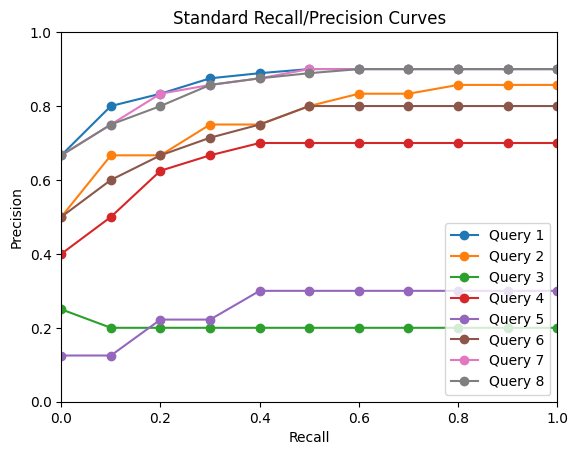

<ipython-input-14-a61d72392951>:239: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(x_axis, y_axis, '-bo', color="blue", label="Average")


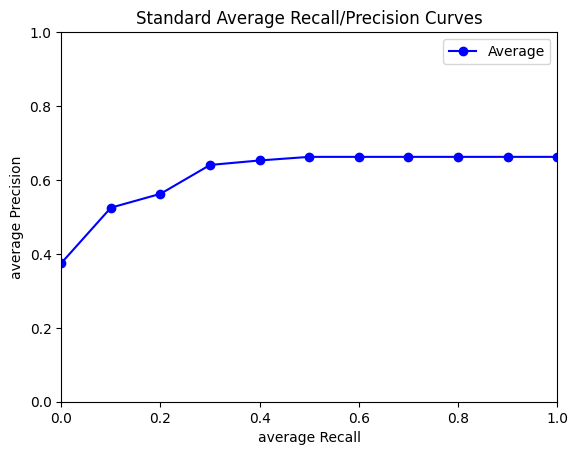

In [14]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt


# This function processes the query by cleaning and applying TFIDF
def process_query(query, vocab, weightScheme):
    query = clean_data(query)
    line = ' '.join(query)
    vectorizer = CountVectorizer(vocabulary=vocab)
    transformer = TfidfTransformer(norm=weightScheme)
    encoded = transformer.fit_transform(vectorizer.fit_transform([line]))
    return encoded

# This function processes the data by appyling TFIDF
def vectorize_data(data, vocab, weightScheme):
    vectorizer = CountVectorizer(vocabulary=vocab)
    transformer = TfidfTransformer(norm= weightScheme)
    data_transformed = transformer.fit_transform(vectorizer.fit_transform(data))
    return data_transformed

# This function gets the queries needed to test this model
def get_queries(dataFrame):
    if len(dataFrame.columns) >= 17:
        # Extract values from columns 10 to 18 of the first row and convert to strings
        values_list = [str(dataFrame.iloc[0, i]) for i in range(9, 17)]
        return values_list

# This function gets the relavent ids for each query
# for calculating precision, recall and f1
def get_relevant_ids(dataFrame):
    relevant_ids = []
    for column in dataFrame.columns[:8]:  # Loop through the first 8 columns
        column_values = dataFrame[column].dropna().astype(int).tolist()
        relevant_ids.append(column_values)

    return relevant_ids


# This function was created to calulate recall
def calculate_recall(rel, actual):
  number_of_relevant_ids = len(actual)
  recall = []
  total_relevant = 0
  for i in range(0, len(rel)):
    total_relevant += rel[i]

    r = total_relevant / number_of_relevant_ids
    recall.append(r)
  return recall

# This function was created to calculate precision
def calculate_precision(rel):
    precision = []
    total_relevant = 0
    for i in range(1, len(rel) + 1):
        total_relevant += rel[i - 1]

        if i != 0:
            p = total_relevant / i
        else:
            p = 0
        precision.append(p)

    return precision

# This function was created to calculate f1
def calculate_f1(precision, recall):
    F1 = []

    for i in range(len(precision)):


        if precision[i] + recall[i] != 0:
            f = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i])
        else:
            f = 0
        F1.append(f)
    return F1


# Interplot Precision for standard Recall
def InterplotPrecision(p=0.1, Precision=None, Recall=None):

    if p >= 1.0:
        p = 0.9
    Mark = np.zeros(2)
    l = 0
    r = 0
    for i in range(len(Recall)):
        if Recall[i] >= p and Mark[0] == 0:
            l = i
            Mark[0] = 1
        if Recall[i] >= p + 0.1 and Mark[1] == 0:
        # if Recall[i] >= 1.0 and Mark[1] == 0:
            r = i
            Mark[1] = 1

    if (r < l) or (r==0 and l==0):

      y = Precision[-1]
    else:
      y = max(Precision[l:(r+1)])
    return y

# obtain y axis for R/P curve
def compute_RP_yaxis(Precision=None, Recall=None):
  y_axis = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

  for i in range(11):
    pInput = 0.1 * i
    y_axis[i] = InterplotPrecision(p=pInput, Precision=Precision, Recall=Recall)
  return y_axis

# get queries and process
file2 = '/content/drive/MyDrive/Colab Notebooks/COP509cw/Datasets/JewelleryReviewsQueryRelevantID.csv'
querydf = pd.read_csv(file2)
queries = get_queries(querydf)

# get relevant ids
relevant_ids = get_relevant_ids(querydf)

# apply TFIDF on data
data_transformed = vectorize_data(data, vocab, 'l2')
# apply SVD on data
trunc_SVD_model = TruncatedSVD(n_components=50)
data_vectorized = trunc_SVD_model.fit_transform(data_transformed)

# mapping from id to vectorized document
id_to_vectorized = dict(zip(ids, data_vectorized))


# number of docs to retrieve
n = 10
j = 1

AllRecall = []
AllPrecision = []
AllF1measure = []

# Find similarities for each query
for query, query_relevant_ids in zip(queries, relevant_ids):

    # apply TFIDF on query
    processed_query = process_query(query, vocab, 'l2')
    # SVD on query
    transformed_query = trunc_SVD_model.transform(processed_query)
    # calculate similarities for data and query
    similarities = cosine_similarity(data_vectorized, transformed_query)
    # get indexes for top 10 documents
    indexes = np.argsort(similarities.flat)[-n:]

    # Retrieve the top n vectorized documents
    top_n_vectorized = data_vectorized[indexes]

    # Map the vectorized documents back to their corresponding IDs
    top_n_ids_lsi = [id for id, vectorized in id_to_vectorized.items() if vectorized in top_n_vectorized]

    # Mark the relevant index
    re_mark = []
    for i in range(0, n):
        if top_n_ids_lsi[i] in query_relevant_ids:
            re_mark.append(1)
        else:
            re_mark.append(0)

    print("Query:{}".format(j))

    print("Top n document IDs: " + str(top_n_ids_lsi))
    print("Actual relevant ids:" + str(query_relevant_ids))

    print("Relevant", re_mark)

    precision = calculate_precision(re_mark)
    print("precision:", precision)

    recall = calculate_recall(re_mark, query_relevant_ids)
    print("Recall:", recall)

    F1 = calculate_f1(precision, recall)
    print("F1 Score", F1)

    print("-" * 200)

    # save
    AllRecall.append(recall)
    AllPrecision.append(precision)
    AllF1measure.append(F1)

    # plot R/P curve for each query
    x_axis = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    y_axis = compute_RP_yaxis(Precision=precision, Recall=recall)
    plt.plot(x_axis, y_axis, '-o', label="Query %d" % (j))

    j += 1

# Put in numpy array
AllRecall = np.array(AllRecall)
AllPrecision = np.array(AllPrecision)
AllF1measure = np.array(AllF1measure)

# Compute average Recall, average Precision, average F1-measure for all queries
AveRecall = np.mean(AllRecall, axis=0)
AvePrecision = np.mean(AllPrecision, axis=0)
AveF1measure = np.mean(AllF1measure, axis=0)

# Calculate standard deviation
StdRecall = np.std(AllRecall, axis=0)
StdPrecision = np.std(AllPrecision, axis=0)
StdF1measure = np.std(AllF1measure, axis=0)

print("\nAverage Recall, average Precision, average F1-measure: ")
print("average Recall@1~10: ", np.around(AveRecall[:10],2))
print("average Precision@1~10: ", np.around(AvePrecision[:10],2))
print("average F1measure@1~10: ", np.around(AveF1measure[:10],2))

print("\nStandard Deviation Recall, Precision, F1-measure: ")
print("Standard Deviation Recall@1~10: ", np.around(StdRecall[:10], 2))
print("Standard Deviation Precision@1~10: ", np.around(StdPrecision[:10], 2))
print("Standard Deviation F1measure@1~10: ", np.around(StdF1measure[:10], 2))

# Display the overall plot after all queries

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Standard Recall/Precision Curves')
plt.legend()
plt.show()


# plot average R/P curve

x_axis = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
y_axis = compute_RP_yaxis(Precision=AvePrecision, Recall=AveRecall)
plt.plot(x_axis, y_axis, '-bo', color="blue", label="Average")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('average Recall')
plt.ylabel('average Precision')
plt.title('Standard Average Recall/Precision Curves')
plt.legend()
plt.show()


## 2B & 2C - Model Tuning with Evaluation

This code block optimizes the model by looping through all the different combinations of component values for the SVD dimensions with the 'norm' value of scikit learns TFIDF parameter. The average precison, recall and f1 is calculated and plotted. The best combination of oparameters is determined by the best average f1 score.

Tune setting 1: 
number of components - 10, 
Norm scheme - l1

Average Recall, average Precision, average F1-measure: 
average Recall@1~10:  [0.01 0.02 0.08 0.15 0.23 0.33 0.43 0.53 0.61 0.69]
average Precision@1~10:  [0.12 0.12 0.29 0.44 0.52 0.6  0.66 0.7  0.72 0.74]
average F1measure@1~10:  [0.02 0.03 0.12 0.22 0.31 0.41 0.5  0.58 0.63 0.68]

Standard Deviation of Recall, Precision, F1-measure: 
Std Dev of Recall@1~10:  [0.03 0.05 0.08 0.11 0.14 0.15 0.17 0.2  0.19 0.2 ]
Std Dev of Precision@1~10:  [0.33 0.33 0.31 0.27 0.26 0.22 0.19 0.16 0.15 0.14]
Std Dev of F1measure@1~10:  [0.05 0.09 0.12 0.14 0.17 0.15 0.14 0.14 0.11 0.08]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Tune setting 2: 
number of components - 10, 
Norm scheme - l2

Average Recall, average Precision, average F1-measure: 
average Recall@1~10:  [0.03 0.08 0.13 0.2

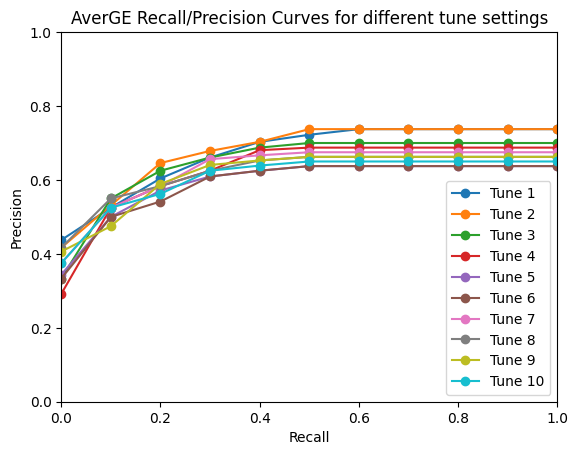

<Figure size 640x480 with 0 Axes>

In [15]:
from IPython.display import clear_output

# get queries
file2 = '/content/drive/MyDrive/Colab Notebooks/COP509cw/Datasets/JewelleryReviewsQueryRelevantID.csv'
querydf = pd.read_csv(file2)
queries = get_queries(querydf)

# get relevant ids

relevant_ids = get_relevant_ids(querydf)

component_values = [10, 20, 30, 40, 50]
norm_schemes = ['l1', 'l2']

a = 1

best_avg_f1 = 0.0
best_norm = ''
best_n_comp = 0
tuned_model = 0

# Experiment with different parameters
for n_components in component_values:
    for norm in norm_schemes:

        # SVD on data
        data_transformed = vectorize_data(data, vocab, norm)
        trunc_SVD_model = TruncatedSVD(n_components=n_components)
        data_vectorized = trunc_SVD_model.fit_transform(data_transformed)


        # mapping from id to vextorized document
        id_to_vectorized = dict(zip(ids, data_vectorized))


        n = 10
        j = 1

        AllRecall = []
        AllPrecision = []
        AllF1measure = []

        # Find similarities for each query
        for query, query_relevant_ids in zip(queries, relevant_ids):
            processed_query = process_query(query, vocab, norm)

            transformed_query = trunc_SVD_model.transform(processed_query)
            similarities = cosine_similarity(data_vectorized, transformed_query)
            indexes = np.argsort(similarities.flat)[-n:]

            # Retrieve the top n vectorized documents
            top_n_vectorized = data_vectorized[indexes]

            # Map the vectorized documents back to their corresponding IDs
            top_n_ids_lsi = [id for id, vectorized in id_to_vectorized.items() if vectorized in top_n_vectorized]

            # Mark the relevant index
            re_mark = []
            for i in range(0, n):
                if top_n_ids_lsi[i] in query_relevant_ids:
                    re_mark.append(1)
                else:
                    re_mark.append(0)


            precision = calculate_precision(re_mark)
            recall = calculate_recall(re_mark, query_relevant_ids)
            F1 = calculate_f1(precision, recall)

              # save
            AllRecall.append(recall)
            AllPrecision.append(precision)
            AllF1measure.append(F1)


            j +=1

        # compute average Recall, average Precision, average F1-measure

        AllRecall = np.array(AllRecall)
        AllPrecision = np.array(AllPrecision)
        AllF1measure = np.array(AllF1measure)

        # Compute average Recall, average Precision, average F1-measure for all queries
        AveRecall = np.mean(AllRecall, axis=0)
        AvePrecision = np.mean(AllPrecision, axis=0)
        AveF1measure = np.mean(AllF1measure, axis=0)

        # Calculate standard deviation
        StdRecall = np.std(AllRecall, axis=0)
        StdPrecision = np.std(AllPrecision, axis=0)
        StdF1measure = np.std(AllF1measure, axis=0)

        print("Tune setting {}: \nnumber of components - {}, \nNorm scheme - {}".format(a,n_components,norm ))
        print("\nAverage Recall, average Precision, average F1-measure: ")
        print("average Recall@1~10: ", np.around(AveRecall[:10],2))
        print("average Precision@1~10: ", np.around(AvePrecision[:10],2))
        print("average F1measure@1~10: ", np.around(AveF1measure[:10],2))

        print("\nStandard Deviation of Recall, Precision, F1-measure: ")
        print("Std Dev of Recall@1~10: ", np.around(StdRecall[:10], 2))
        print("Std Dev of Precision@1~10: ", np.around(StdPrecision[:10], 2))
        print("Std Dev of F1measure@1~10: ", np.around(StdF1measure[:10], 2))

        print('-'* 200)

        # Update best results if the current iteration is better
        if np.sum(AveF1measure) > best_avg_f1:
            best_avg_f1 = np.sum(AveF1measure)
            best_n_comp = n_components
            best_norm = norm
            tuned_model = a


        # plot R/P curve for each query
        x_axis = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
        y_axis = compute_RP_yaxis(Precision=AvePrecision, Recall=AveRecall)
        plt.plot(x_axis, y_axis, '-o', label="Tune %d" % (a))

        a += 1


# Save the best top N IDs
print("\nBest Tuned model: {}".format(tuned_model))
print("Number of components: {}, Norm scheme: {}".format(best_n_comp, best_norm))
print("Best Average F1-measure:", best_avg_f1)


plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('AverGE Recall/Precision Curves for different tune settings')
plt.legend()
plt.show()
plt.savefig("tuned_models")

## 2B & 2C - Best Model

This code block then re-runs that optimized model to show the precison, recall and f1 for the different queries

Query:1
Top n document IDs: [48216, 44591, 36164, 58481, 26246, 2033, 48779, 34523, 45278, 41876]
Actual relevant ids:[36164, 58481, 26246, 2033, 48779, 34523, 9726, 56494, 49525, 45278, 35694, 41876, 17309, 11135, 17273, 11247]
Relevant [0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
precision: [0.0, 0.0, 0.3333333333333333, 0.5, 0.6, 0.6666666666666666, 0.7142857142857143, 0.75, 0.7777777777777778, 0.8]
Recall: [0.0, 0.0, 0.0625, 0.125, 0.1875, 0.25, 0.3125, 0.375, 0.4375, 0.5]
F1 Score [0, 0, 0.10526315789473684, 0.2, 0.2857142857142857, 0.36363636363636365, 0.43478260869565216, 0.5, 0.56, 0.6153846153846154]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Query:2
Top n document IDs: [57123, 25299, 55017, 7432, 2114, 40871, 13373, 54748, 642, 56865]
Actual relevant ids:[57123, 25299, 55017, 7432, 2114, 40871]
Relevant [1, 1, 1, 1, 1, 1, 0, 0, 0, 0]


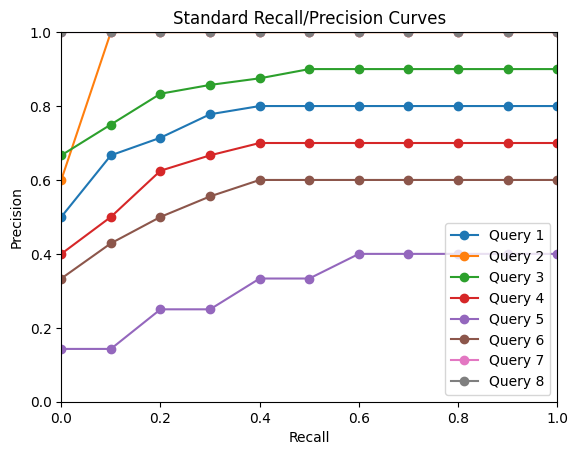

<ipython-input-16-183a685fdef5>:127: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(x_axis, y_axis, '-bo', color="blue", label="Average")


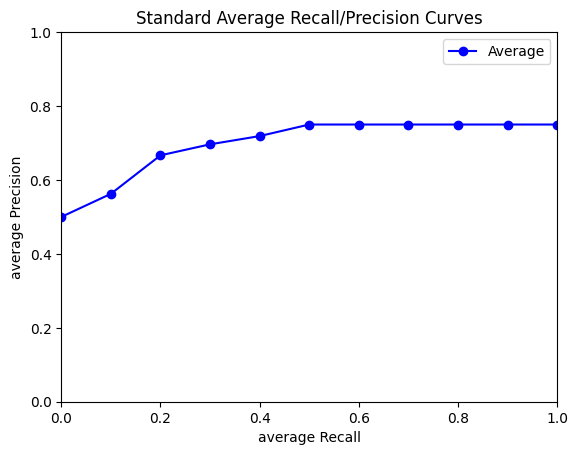

In [16]:
# get queries
file2 = '/content/drive/MyDrive/Colab Notebooks/COP509cw/Datasets/JewelleryReviewsQueryRelevantID.csv'
querydf = pd.read_csv(file2)
queries = get_queries(querydf)

# get relevant ids

relevant_ids = get_relevant_ids(querydf)

# SVD on data
data_transformed = vectorize_data(data, vocab, best_norm)
trunc_SVD_model = TruncatedSVD(n_components=best_n_comp)
data_vectorized = trunc_SVD_model.fit_transform(data_transformed)


# mapping from id to vextorized document
id_to_vectorized = dict(zip(ids, data_vectorized))


n = 10
j = 1


AllRecall = []
AllPrecision = []
AllF1measure = []



# Find similarities for each query
for query, query_relevant_ids in zip(queries, relevant_ids):
    processed_query = process_query(query, vocab, best_norm)

    transformed_query = trunc_SVD_model.transform(processed_query)
    similarities = cosine_similarity(data_vectorized, transformed_query)
    indexes = np.argsort(similarities.flat)[-n:]

    # Retrieve the top n vectorized documents
    top_n_vectorized = data_vectorized[indexes]

    # Map the vectorized documents back to their corresponding IDs
    top_n_ids_lsi = [id for id, vectorized in id_to_vectorized.items() if vectorized in top_n_vectorized]

    # Mark the relevant index
    re_mark = []
    for i in range(0, n):
        if top_n_ids_lsi[i] in query_relevant_ids:
            re_mark.append(1)
        else:
            re_mark.append(0)


    print("Query:{}".format(j))

    print("Top n document IDs: " + str(top_n_ids_lsi))
    print("Actual relevant ids:" + str(query_relevant_ids))

    print("Relevant", re_mark)

    precision = calculate_precision(re_mark)
    print("precision:", precision)

    recall = calculate_recall(re_mark, query_relevant_ids)
    print("Recall:", recall)

    F1 = calculate_f1(precision, recall)
    print("F1 Score", F1)

    print("-" * 200)

    # save
    AllRecall.append(recall)
    AllPrecision.append(precision)
    AllF1measure.append(F1)

    # plot R/P curve for each query
    x_axis = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    y_axis = compute_RP_yaxis(Precision=precision, Recall=recall)
    plt.plot(x_axis, y_axis, '-o', label="Query %d" % (j))

    j += 1




AllRecall = np.array(AllRecall)
AllPrecision = np.array(AllPrecision)
AllF1measure = np.array(AllF1measure)

# compute average Recall, average Precision, average F1-measure
BestAveRecall = np.mean(AllRecall, axis=0)
BestAvePrecision = np.mean(AllPrecision, axis=0)
BestAveF1measure = np.mean(AllF1measure, axis=0)

# Calculate standard deviation
BestStdRecall = np.std(AllRecall, axis=0)
BestStdPrecision = np.std(AllPrecision, axis=0)
BestStdF1measure = np.std(AllF1measure, axis=0)

print("\nAverage Recall, average Precision, average F1-measure: ")
print("average Recall@1~10: ", np.around(BestAveRecall[:10],2))
print("average Precision@1~10: ", np.around(BestAvePrecision[:10],2))
print("average F1measure@1~10: ", np.around(BestAveF1measure[:10],2))

print("\nStandard Deviation of Recall, Precision, F1-measure: ")
print("Std Dev of Recall@1~10: ", np.around(BestStdRecall[:10], 2))
print("Std Dev of Precision@1~10: ", np.around(BestStdPrecision[:10], 2))
print("Std Dev of F1measure@1~10: ", np.around(BestStdF1measure[:10], 2))

# Display the overall plot after all queries

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Standard Recall/Precision Curves')
plt.legend()
plt.savefig("best_model_pr.png")
plt.show()



# plot average R/P curve

x_axis = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
y_axis = compute_RP_yaxis(Precision=BestAvePrecision, Recall=BestAveRecall)
plt.plot(x_axis, y_axis, '-bo', color="blue", label="Average")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('average Recall')
plt.ylabel('average Precision')
plt.title('Standard Average Recall/Precision Curves')
plt.legend()
plt.savefig("best_model_pr_average.png")
plt.show()


# Task 3 (NIR)

## 3a - Using DistilBert

Using the tranformer DistilBert, information retrieval can be acheived. This method begins by tokenising the text and encoding into numerical representations. This are then fed into the model which can capture the semantic meaning of the documents and queries. The created embeddings can then be used. For this task, the queries and data were passed throught the model to create embeddings for both query and the data. Similarly to task 2, cosine similarity was used to determine the most similar documents. Likewise, precision, recall and f1 scores were calculated to determine the performance of the model

In [20]:
!pip install transformers

In [21]:
import torch
import transformers as ppb
import warnings

In [22]:
# For DistilBERT:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

# Load pretrained model/tokenizer
distilTokenizer = tokenizer_class.from_pretrained(pretrained_weights)
distilModel = model_class.from_pretrained(pretrained_weights)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [23]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')

def embed_data(data):
  with torch.no_grad():
      # Tokenization
      tokenized = data.apply((lambda x: distilTokenizer.encode(x, add_special_tokens=True)))

      # padding
      max_len = 0
      q = 0
      for i in tokenized.values:

          # BERT only accept maximum 512 values
          if len(i) > 512:
              temp = tokenized.values[q]
              tokenized.values[q] = temp[:512]
              i = tokenized.values[q]
              print('too much tokenized.values for BERT, only 512 are taken')

          # print(len(i))
          if len(i) > max_len:
              max_len = len(i)
          q += 1

      padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
      np.array(padded).shape

      # masking
      attention_mask = np.where(padded != 0, 1, 0)
      attention_mask.shape

      # run the model
      input_ids = torch.tensor(padded)
      attention_mask = torch.tensor(attention_mask)


      last_hidden_states = distilModel(input_ids, attention_mask=attention_mask)

      train_features = last_hidden_states[0][:,0,:].numpy()

      return train_features

In [24]:
# embed data
train_docs = pd.Series(data)
embeded_data = embed_data(train_docs)

Query:1
Top n document IDs: [642, 10642, 37794, 45518, 735, 10037, 41872, 53409, 56865, 44490]
Actual relevant ids:[36164, 58481, 26246, 2033, 48779, 34523, 9726, 56494, 49525, 45278, 35694, 41876, 17309, 11135, 17273, 11247]
Relevant [1, 0, 1, 0, 0, 1, 0, 0, 1, 0]
precision: [1.0, 0.5, 0.6666666666666666, 0.5, 0.4, 0.5, 0.42857142857142855, 0.375, 0.4444444444444444, 0.4]
Recall: [0.0625, 0.0625, 0.125, 0.125, 0.125, 0.1875, 0.1875, 0.1875, 0.25, 0.25]
F1 Score [0.11764705882352941, 0.1111111111111111, 0.21052631578947367, 0.2, 0.19047619047619047, 0.2727272727272727, 0.26086956521739124, 0.25, 0.32, 0.3076923076923077]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Query:2
Top n document IDs: [642, 10642, 37794, 45518, 735, 10037, 41872, 53409, 56865, 44490]
Actual relevant ids:[57123, 25299, 55017, 7432, 2114, 40871]
Relevant [1, 0

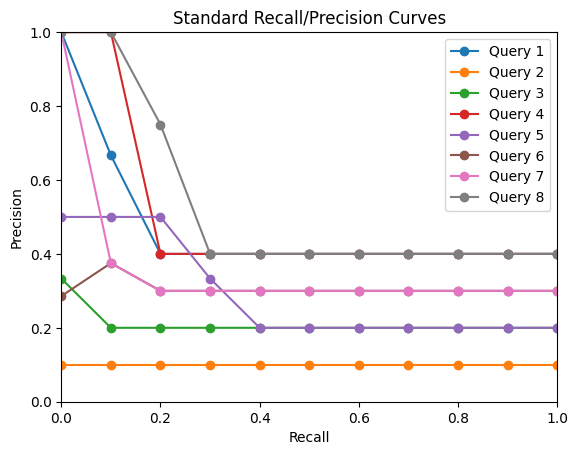

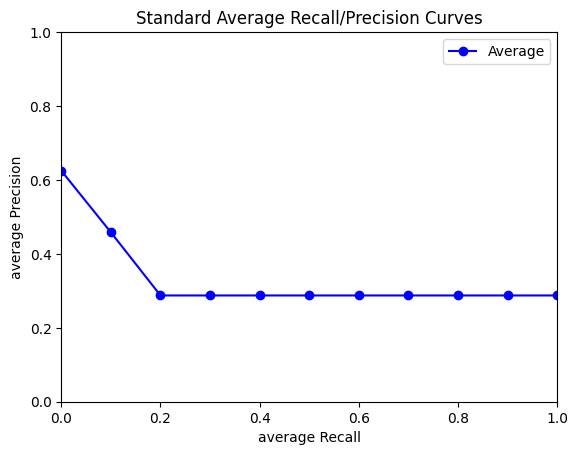

In [25]:
# get queries
file2 = '/content/drive/MyDrive/Colab Notebooks/COP509cw/Datasets/JewelleryReviewsQueryRelevantID.csv'
querydf = pd.read_csv(file2)
queries = get_queries(querydf)

# mapping from id to vextorized document
id_to_vectorized = dict(zip(ids, embeded_data))

j=1
n = 10
AllRecall = []
AllPrecision = []
AllF1measure = []

for query, query_relevant_ids in zip(queries, relevant_ids):

    query = clean_data(query)
    query_line = ' '.join(query)
    query_docs = pd.Series(query_line)
    embeded_query = embed_data(query_docs)
    similarities = cosine_similarity(embeded_data, embeded_query)

    indexes = np.argsort(similarities.flat)[-n:]

    # Retrieve the top n vectorized documents
    top_n_vectorized = data_vectorized[indexes]

    # Find the indices of the top n similarity values
    top_n_indices = np.argsort(similarities.flat)[-n:][::-1]

    # Map the indices back to the corresponding IDs
    top_n_ids_nir = [ids[idx] for idx in top_n_indices]

    # Mark the relevant index
    re_mark = [1 if top_n_id in query_relevant_ids else 0 for top_n_id in top_n_ids_nir]

    print("Query:{}".format(j))

    print("Top n document IDs: " + str(top_n_ids_lsi))
    print("Actual relevant ids:" + str(query_relevant_ids))

    print("Relevant", re_mark)

    precision = calculate_precision(re_mark)
    print("precision:", precision)

    recall = calculate_recall(re_mark, query_relevant_ids)
    print("Recall:", recall)

    F1 = calculate_f1(precision, recall)
    print("F1 Score", F1)

    print("-" * 200)

    # save
    AllRecall.append(recall)
    AllPrecision.append(precision)
    AllF1measure.append(F1)

    # plot R/P curve for each query
    x_axis = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    y_axis = compute_RP_yaxis(Precision=precision, Recall=recall)
    plt.plot(x_axis, y_axis, '-o', label="Query %d" % (j))

    j += 1

# compute average Recall, average Precision, average F1-measure
AllRecall = np.array(AllRecall)
AllPrecision = np.array(AllPrecision)
AllF1measure = np.array(AllF1measure)

# compute average Recall, average Precision, average F1-measure
NIRAveRecall = np.mean(AllRecall, axis=0)
NIRAvePrecision = np.mean(AllPrecision, axis=0)
NIRAveF1measure = np.mean(AllF1measure, axis=0)

# Calculate standard deviation
NIRStdRecall = np.std(AllRecall, axis=0)
NIRStdPrecision = np.std(AllPrecision, axis=0)
NIRStdF1measure = np.std(AllF1measure, axis=0)

print("\nAverage Recall, average Precision, average F1-measure: ")
print("average Recall@1~10: ", np.around(NIRAveRecall[:10],2))
print("average Precision@1~10: ", np.around(NIRAvePrecision[:10],2))
print("average F1measure@1~10: ", np.around(NIRAveF1measure[:10],2))

print("\nStandard Deviation of Recall, Precision, F1-measure: ")
print("Std Dev of Recall@1~10: ", np.around(NIRStdRecall[:10], 2))
print("Std Dev of Precision@1~10: ", np.around(NIRStdPrecision[:10], 2))
print("Std Dev of F1measure@1~10: ", np.around(NIRStdF1measure[:10], 2))

# Display the overall plot after all queries

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Standard Recall/Precision Curves')
plt.legend()
plt.savefig("nir_pr.png")
plt.show()


# plot average R/P curve

x_axis = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
y_axis = compute_RP_yaxis(Precision=NIRAvePrecision, Recall=NIRAveRecall)
plt.plot(x_axis, y_axis, '-bo', color="blue", label="Average")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('average Recall')
plt.ylabel('average Precision')
plt.title('Standard Average Recall/Precision Curves')
plt.legend()
plt.savefig("nir_pr_average.png")
plt.show()

## 3B Results comparison

### Plots

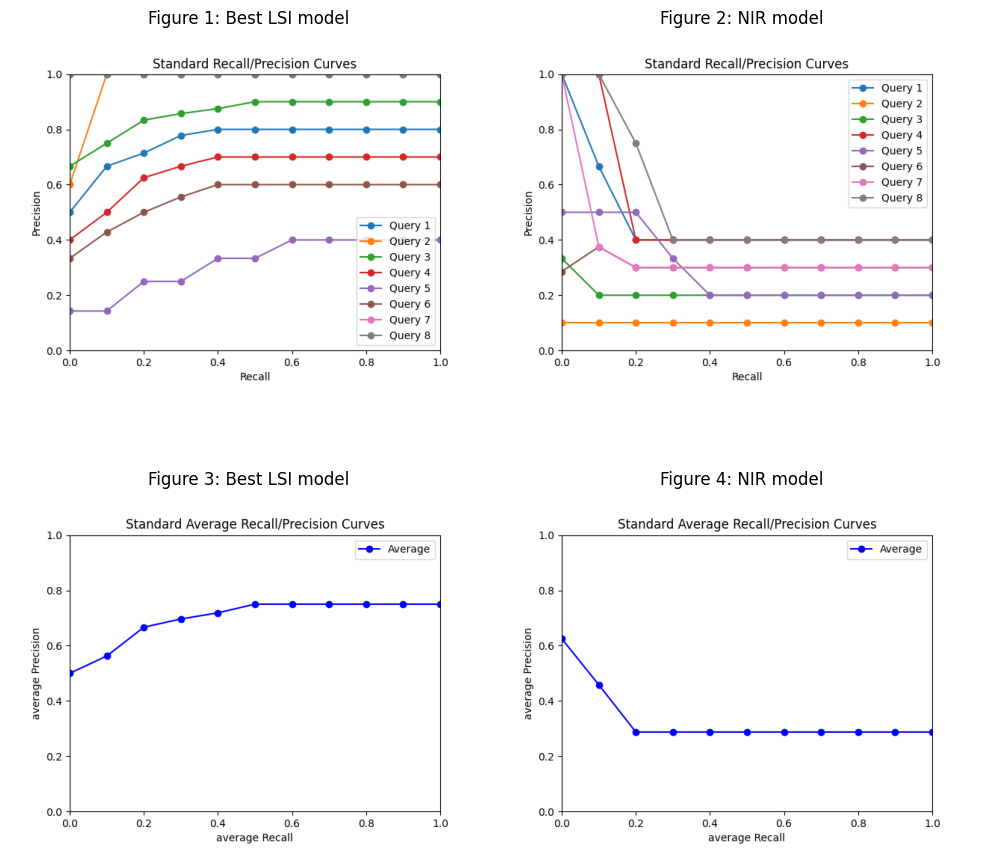

In [26]:
from IPython.display import Image, display
import matplotlib.image as mpimg

# Specify the filenames for your images
image_filenames = ["/content/best_model_pr.png", "/content/nir_pr.png", "/content/best_model_pr_average.png", "/content/nir_pr_average.png"]

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Titles for the images
image_titles = ["Figure 1: Best LSI model", "Figure 2: NIR model", "Figure 3: Best LSI model", "Figure 4: NIR model"]

# Iterate through the images and display them in the grid
for i, ax in enumerate(axes.flat):
    img = mpimg.imread(image_filenames[i])
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(image_titles[i])  # Set the title based on the index

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


### Table of results

In [27]:
# Define the data
LSIAverage = [BestAveRecall[9], BestAvePrecision[9], BestAveF1measure[9]]
NIRAverage = [NIRAveRecall[9], NIRAvePrecision[9], NIRAveF1measure[9]]
LSISTD = [BestStdRecall[9], BestStdPrecision[9], BestStdF1measure[9]]
NIRSTD = [NIRStdRecall[9], NIRStdPrecision[9], NIRStdF1measure[9]]

# Create a dictionary with the data
results = {
    'Best LSI Average': LSIAverage,
    'NIR Average': NIRAverage,
    'LSI Standard deviation': LSISTD,
    'NIR standard deviation': NIRSTD
}


resultsdf = pd.DataFrame(results, index=['Recall', 'Precision', 'F1 Measure'])

resultsdf


,Best LSI Average,NIR Average,LSI Standard deviation,NIR standard deviation
Recall,0.678297,0.252152,0.167516,0.076458
Precision,0.750000,0.287500,0.200000,0.105327
F1 Measure,0.685051,0.258739,0.123580,0.072969


### Results discussion

As shown above, Figure 1 displays the recall - precision graph for each query for the best tuned LSI model. In comparison, Figure 2 displays the recall - precision graph for the NIR model. As observed, the LSI model performs much better for each query with an increase in precision though the documents however, the NIR model struggles to perform well. In addition, the overall averages are calculated for the queries for each document as displayed in figure 3 and 4. In figure 3, this shows that the LSI model performs really well and gradually decreases in precision througghout the docuemnts. This is to be expected as the number of relevant documents might be less than the number of retrieved documents (in this case - 10). However, as displayed in figure 4, the NIR on average can retrieve a few relavent documents for the first few documents and then stops accuratly retrieving relavent documents almost instantly. In the table above displays the averages and standard deviation of the F1 score calculated after the 10th retrieved document. The results further indicate that LSI model performs much better than the NIR model.

## 3C - Interactive UI using best model

These code blocks use IPy widgets and the LSI model (with the best tuned parameters) to allow a user to type in a query and the number of relative documents they would like to retrieve. The ids and assiociated reviews (as raw text) is displayed

In [28]:


all_reviews = []

def retrieve_top_docs(_):

    clear_output(wait=True)
    display(allw)
    query = query_field.value
    n = n_doc_field.value

    # Check if query or n is empty
    if not query or not n:
        print("Please enter both a query and a value for the number of documents.")
        return

    try:
        n = int(n)
        if n <= 0:
            print("Please enter a valid positive value for the number of documents.")
            return
    except ValueError:
        print("Please enter a valid numeric value for the number of documents.")
        return

    # SVD on data
    data_transformed = vectorize_data(data, vocab, best_norm)
    trunc_SVD_model = TruncatedSVD(n_components=best_n_comp)
    data_vectorized = trunc_SVD_model.fit_transform(data_transformed)

    # mapping from id to vectorized document
    id_to_vectorized = dict(zip(ids, data_vectorized))

    # Find similarities for each query
    processed_query = process_query(query, vocab, best_norm)

    transformed_query = trunc_SVD_model.transform(processed_query)
    similarities = cosine_similarity(data_vectorized, transformed_query)
    indexes = np.argsort(similarities.flat)[-n:]

    # Retrieve the top n vectorized documents
    top_n_vectorized = data_vectorized[indexes]

    # Map the vectorized documents back to their corresponding IDs
    top_n_ids = [id for id, vectorized in id_to_vectorized.items() if vectorized in top_n_vectorized]

    for id in top_n_ids:

        # get the raw review for printing
        raw_review = id_to_raw_data.get(id, None)
        # get cleaned review for future use
        cleaned_review = id_to_clean_data.get(id, None)
        all_reviews.append(cleaned_review)

        print(id, raw_review)
        print("-" * 200)

    return


In [29]:
# Search button
search_button = widgets.Button(description="Search")
search_button.on_click(retrieve_top_docs)

# query field
query_field = widgets.Text(description="Enter Query:")
n_doc_field = widgets.Text(description="Enter the number of related documents you wish to retrieve:")

#H layout
fields = widgets.HBox([query_field, n_doc_field])

output = widgets.Output()

allw = widgets.VBox([fields, search_button, output])

In [30]:
# display widgets
display(allw)

43515 This ring is a beautiful ring but the first shipment of this ring had scratches on the diamond and was missing 2 diamonds on the shoulder of the ring. I returned the ring for a replacement of the same ring, the second ring was even worse. Clearly visible white scratch right in the middle of a black diamond does not look that great. And this time 1 diamond missing on the shoulder of the ring. I returned it for a refund. Thanks alot Amazon.
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
28250 I wanted to know if this ring is like 2 rings in one, because this ring is beyond gorgeous, I just love it.
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
36727 I only had it a week before o

# Task 4 (Clustering)

## 4a - Bert topic

The following code blocks use Berttopic for topic modelling. The text data is first transformed using the pre-trained model and embedded to capture the semantic meaning. The model then undergoes dimensional reduction using SVD and then clustered using Kmean.

 To run the following code in this section, make sure to run the code for section 3C and enter a query and number of retrieved documents. The following example uses 50 retrieved documents obtained from the model in task 3C for the query 'This is really great'.

In [31]:
%%capture
!pip install bertopic

In [32]:
# print to see the reviews entering the Bert topic model

#print(all_reviews)

In [33]:
print(len(all_reviews))

50


In [34]:
# Please select from (UMAP, SVD, PCA)
RedDiMethod = 'SVD'

In [44]:
from sentence_transformers import SentenceTransformer
from umap import UMAP
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.cluster import KMeans
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic import BERTopic
from sklearn.cluster import DBSCAN

# Step 1 - Extract embeddings
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Step 2 - Reduce dimensionality
if RedDiMethod == 'SVD':
   RD_model = TruncatedSVD(n_components=20)
elif RedDiMethod == 'PCA':
   RD_model = PCA(n_components='mle')
else:
   RD_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine')

n_clusters = 5
# Step 3 - Cluster reduced embeddings
Cluster_model = KMeans(n_clusters=n_clusters, random_state=42)


# Step 4 - Tokenize topics
vectorizer_model = CountVectorizer(stop_words="english")

# Step 5 - Create topic representation
ctfidf_model = ClassTfidfTransformer()

# All steps together
topic_model = BERTopic(
  embedding_model=embedding_model,    # Step 1 - Extract embeddings
  umap_model=RD_model,                # Step 2 - Reduce dimensionality
  hdbscan_model=Cluster_model,        # Step 3 - Cluster reduced embeddings
  vectorizer_model=vectorizer_model,  # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model,          # Step 5 - Extract topic words
  calculate_probabilities=True
)

topics, probs = topic_model.fit_transform(all_reviews)

Here shows the count and key words for each cluster

In [45]:
freq = topic_model.get_topic_info()
freq.head(n_clusters)

,Topic,Count,Name,Representation,Representative_Docs
0,0,20,0_ring_love_great_bought,"[ring, love, great, bought, diamond, like, loo...",[ring beautiful ring first shipment ring scrat...
1,1,12,1_gift_item_great_quality,"[gift, item, great, quality, seller, jewelry, ...",[love birthstone wanted piece jewelry symboliz...
2,2,8,2_ring_wear_ear_cut,"[ring, wear, ear, cut, couldn, wish, comfortab...",[bought ring valentine gift couldn't give sinc...
3,3,6,3_beautiful_looking_bead_color,"[beautiful, looking, bead, color, forward, pre...",[imagine sparkling around girlfriend tanned to...
4,4,4,4_wearing_classy_work_wear,"[wearing, classy, work, wear, hat, pro, sport,...",[day wear blue one wear one really enjoy weari...


This shows the most frquent words for the first cluster

In [46]:
topic_model.get_topic(0)

[('ring', 0.18604069640430987),
 ('love', 0.07982530867265855),
 ('great', 0.05914236175572094),
 ('bought', 0.05352098136161623),
 ('diamond', 0.05136636650087591),
 ('like', 0.041441590691185),
 ('look', 0.041441590691185),
 ('loved', 0.03898129889712401),
 ('beautiful', 0.03778460972256646),
 ('price', 0.037207387001368566)]

Here shows the cluster distance on a graph. Note that this does not show when convert to pdf:

In [47]:
topic_model.visualize_topics()

## 4B - Finding optimal number of clusters

### Elbow Method

To find the optimal number of clusters, two methods were explored to find the best number clusters for this data. Firstly, the elbow method was used as shown below. The optimal number of clusters is where the rate of decrease of interia to clusters slows down i.e. the elbow.

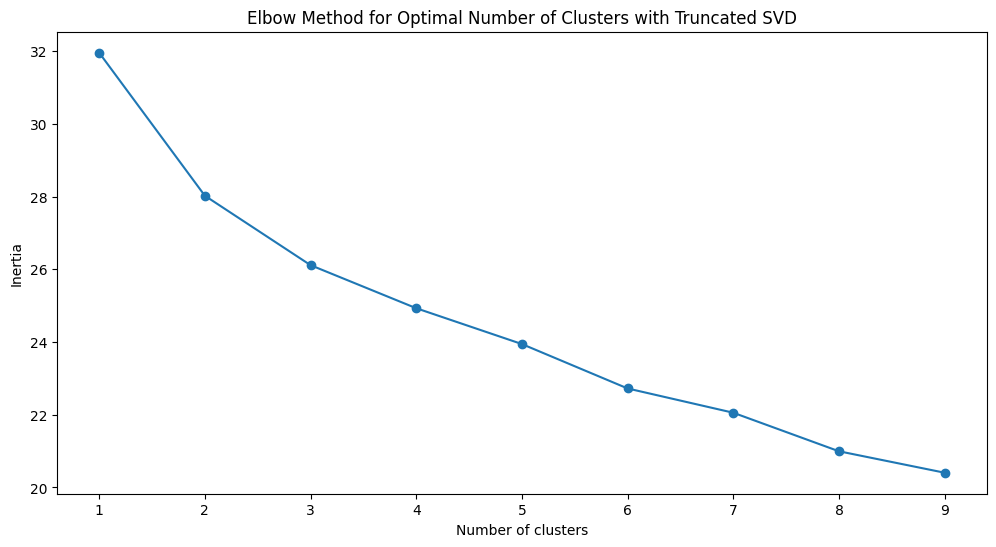

In [48]:
# source: https://www.analyticsvidhya.com/blog/2019/08/comprehensive-guide-k-means-clustering/#:~:text=One%20commonly%20used%20method%20to,distances%20begins%20to%20level%20off.

from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
import pandas as pd
import matplotlib.pyplot as plt

# Step 1 - Extract embeddings
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = embedding_model.encode(all_reviews)


# Fitting multiple k-means algorithms and storing the values in an empty list
SSE = []
for cluster in range(1, 10):
    kmeans = KMeans(n_clusters=cluster, init='k-means++')
    kmeans.fit(embeddings)  # Use the reduced embeddings for clustering
    SSE.append(kmeans.inertia_)

# Converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster': range(1, 10), 'SSE': SSE})
plt.figure(figsize=(12, 6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters with Truncated SVD')
plt.show()


As shown above, the gradient slows down at 2 - 4 clusters, so between 2 - 4 clusters is optimal

### Silhouette Method

The silhouette method evaluates the quality of clusters based on how well-separated they are and how close the data points are to their own clusters compared to neighboring clusters. The silhouette score measures this cohesion and separation, with values ranging from -1 to 1, where higher values indicate better clustering. The point at which the score, is greatest, is the most optimal number of clusters

Optimal number of clusters: 2


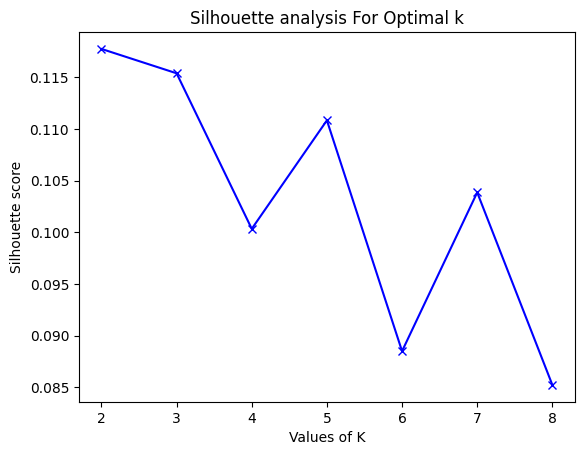

In [55]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import TruncatedSVD


# Step 1 - Extract embeddings
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = embedding_model.encode(all_reviews)

# Define potential cluster numbers
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

# Initialize a list to store silhouette scores
silhouette_avg = []

# Iterate over different cluster numbers
for num_clusters in range_n_clusters:
    # Initialize KMeans model
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(embeddings)

    # Get cluster labels
    cluster_labels = kmeans.labels_

    # Calculate silhouette score
    silhouette_avg.append(silhouette_score(embeddings, cluster_labels))

# Find the optimal number of clusters (highest silhouette score)
optimal_clusters = range_n_clusters[silhouette_avg.index(max(silhouette_avg))]
print(f"Optimal number of clusters: {optimal_clusters}")

# Plot silhouette scores
plt.plot(range_n_clusters, silhouette_avg, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Silhouette score')
plt.title('Silhouette analysis For Optimal k')
plt.show()


As shown in this example, tthe most optimal number of clusters is 2.

## Optimized model

This code re does the Bert topic modelling using 2 clusters which was deemed to be the most optimal

In [56]:
from sentence_transformers import SentenceTransformer
from umap import UMAP
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.cluster import KMeans
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic import BERTopic
from sklearn.cluster import DBSCAN

# Step 1 - Extract embeddings
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Step 2 - Reduce dimensionality
if RedDiMethod == 'SVD':
   RD_model = TruncatedSVD(n_components=20)
elif RedDiMethod == 'PCA':
   RD_model = PCA(n_components='mle')
else:
   RD_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine')


# Step 3 - Cluster reduced embeddings
Cluster_model = KMeans(n_clusters= 2, random_state=42)

# Step 4 - Tokenize topics
vectorizer_model = CountVectorizer(stop_words="english")

# Step 5 - Create topic representation
ctfidf_model = ClassTfidfTransformer()

# All steps together
topic_model = BERTopic(
  embedding_model=embedding_model,    # Step 1 - Extract embeddings
  umap_model=RD_model,                # Step 2 - Reduce dimensionality
  hdbscan_model=Cluster_model,        # Step 3 - Cluster reduced embeddings
  vectorizer_model=vectorizer_model,  # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model,          # Step 5 - Extract topic words
  calculate_probabilities=True
)

topics, probs = topic_model.fit_transform(all_reviews)

## 4C - Evaulation

The following blocks display different evaluation methods to analyse the performance if the topic model with 2 clusters

In [57]:
freq = topic_model.get_topic_info(); freq.head(n_clusters)

,Topic,Count,Name,Representation,Representative_Docs
0,0,25,0_ring_love_great_bought,"[ring, love, great, bought, gift, diamond, wea...",[ring beautiful ring first shipment ring scrat...
1,1,25,1_wearing_great_gift_item,"[wearing, great, gift, item, beautiful, lookin...",[one beautiful rosary seen smoothness color be...


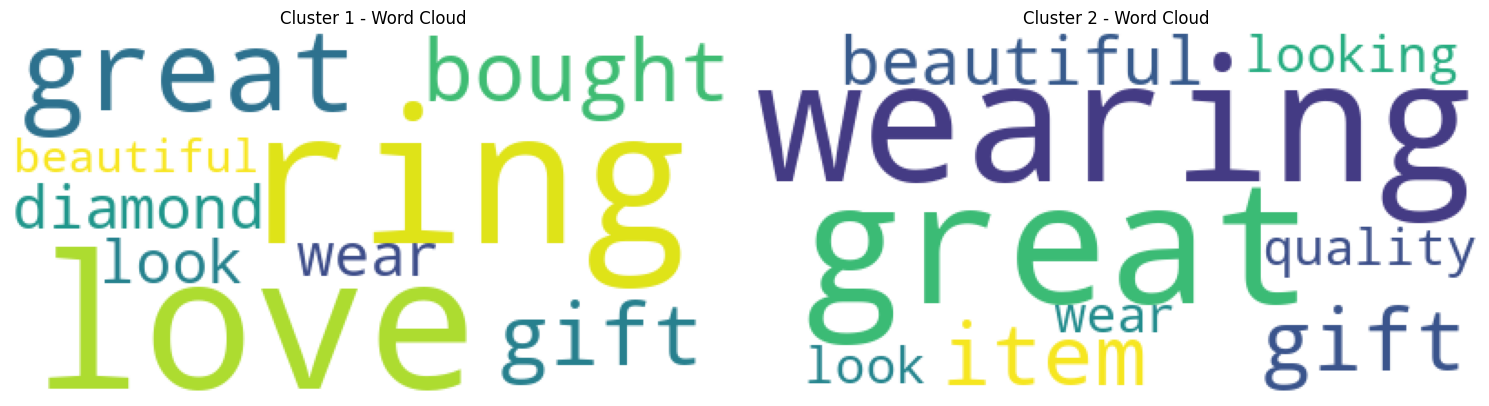

In [58]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

word_cloud_images = []

for cluster in range(2):
    words = topic_model.get_topic(cluster)
    words_list = [word[0] for word in words]

    wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
    wordcloud.generate(' '.join(words_list))

    # Append the word cloud image to the list
    word_cloud_images.append(wordcloud.to_image())

# Display the word cloud images side by side
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for i, image in enumerate(word_cloud_images):
    axes[i].imshow(image)
    axes[i].set_title(f'Cluster {i + 1} - Word Cloud')
    axes[i].axis('off')

plt.tight_layout()
plt.show()


In [59]:
topic_model.get_topic(0)  # Select the most frequent topic

[('ring', 0.31881683263936944),
 ('love', 0.12210406376395636),
 ('great', 0.08373956345985002),
 ('bought', 0.06730216602887347),
 ('gift', 0.054554811578092166),
 ('diamond', 0.053834016378258236),
 ('wear', 0.051778263722971195),
 ('look', 0.04535643590681279),
 ('like', 0.04535643590681279),
 ('beautiful', 0.04218311261495149)]

The following two visualisations do not show when converted to pdf format

In [60]:
topic_model.visualize_hierarchy(top_n_topics=n_clusters)

In [61]:
topic_model.visualize_barchart(top_n_topics=n_clusters)

## 4D & 4E - Interactive UI

Below combines the LSI model with the Bert topic modelling. The user can type in a query and the number of retrieved documents they would like to recieve. The algorithm then finds the optimal number of clusters from that data and then clusters into topics. Note the data is entering Bert topic uses the cleaned data but is converted back to the raw data for printing purposes. Graphs that show statistics about the number of sentences per cluster and the top keywords per cluster are also presented to the user in this code

In [62]:
import ipywidgets as widgets
from IPython.display import clear_output
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

allw = widgets.Output()

reviews = []

def retrieve_top_docs(_):

    clear_output(wait=True)
    display(allw)
    query = query_field.value
    n = n_doc_field.value

    all_reviews = []

    # Check if query or n is empty
    if not query or not n:
        print("Please enter both a query and a value for the number of documents.")
        return
    try:
        n = int(n)
        if n <= 0:
            print("Please enter a valid positive value for the number of documents.")
            return
    except ValueError:
        print("Please enter a valid numeric value for the number of documents.")
        return


    # mapping from id to vectorized document
    id_to_vectorized = dict(zip(ids, data_vectorized))

    # Find similarities for each query
    processed_query = process_query(query, vocab, best_norm)

    transformed_query = trunc_SVD_model.transform(processed_query)
    similarities = cosine_similarity(data_vectorized, transformed_query)
    indexes = np.argsort(similarities.flat)[-n:]

    # Retrieve the top n vectorized documents
    top_n_vectorized = data_vectorized[indexes]

    # Map the vectorized documents back to their corresponding IDs
    top_n_ids = [id for id, vectorized in id_to_vectorized.items() if vectorized in top_n_vectorized]

    for id in top_n_ids:
        raw_review = id_to_raw_data.get(id, None)
        cleaned_review = id_to_clean_data.get(id, None)

        all_reviews.append(cleaned_review)

    reviews.append(all_reviews)
    apply_clustering(all_reviews)

    return

def embed_model(reviews):

    embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
    embeddings = embedding_model.encode(reviews)

    return embeddings


def optimize_clustering(reviews):

    print("Finding optimal number of clusters...")
    embeddings = embed_model(reviews)
    # Define the valid range for the number of clusters
    n_samples = len(reviews)
    valid_range_n_clusters = list(range(2, min(n_samples, 8) + 1))

    # Initialize a list to store silhouette scores
    silhouette_avg = []

    # Iterate over different cluster numbers in the valid range
    for num_clusters in valid_range_n_clusters:
        # Initialize KMeans model
        kmeans = KMeans(n_clusters=num_clusters)
        kmeans.fit(embeddings)

        # Get cluster labels
        cluster_labels = kmeans.labels_

        # Calculate silhouette score
        silhouette_avg.append(silhouette_score(embeddings, cluster_labels))

    # Find the optimal number of clusters (highest silhouette score)
    optimal_clusters = valid_range_n_clusters[silhouette_avg.index(max(silhouette_avg))]

    return optimal_clusters

def apply_clustering(reviews):


    optimal_clusters = optimize_clustering(reviews)
    print("Number of clusters", optimal_clusters)

    # Step 1 - Extract embeddings
    embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

    # Step 2 - Reduce dimensionality
    if RedDiMethod == 'SVD':
        RD_model = TruncatedSVD(n_components=50)
    elif RedDiMethod == 'PCA':
        RD_model = PCA(n_components='mle')
    else:
        RD_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine')

    # Step 3 - Cluster reduced embeddings
    Cluster_model = KMeans(n_clusters=optimal_clusters, random_state=42)

    # Step 4 - Tokenize topics
    vectorizer_model = CountVectorizer(stop_words="english")

    # Step 5 - Create topic representation
    ctfidf_model = ClassTfidfTransformer()

    # All steps together
    topic_model = BERTopic(
        embedding_model=embedding_model,  # Step 1 - Extract embeddings
        umap_model=RD_model,  # Step 2 - Reduce dimensionality
        hdbscan_model=Cluster_model,  # Step 3 - Cluster reduced embeddings
        vectorizer_model=vectorizer_model,  # Step 4 - Tokenize topics
        ctfidf_model=ctfidf_model,  # Step 5 - Extract topic words
        calculate_probabilities=True
    )

    topics, probs = topic_model.fit_transform(reviews)

    topic_info = topic_model.get_topic_info()

    # Get the document IDs for each cluster
    cluster_documents = {cluster_id: [] for cluster_id in range(optimal_clusters)}

    for doc_id, cluster_id in enumerate(topics):
        cluster_documents[cluster_id].append(doc_id)

    number_of_sentences_per_cluster = []


    # Print the sentences for each document in each cluster
    for cluster_id, documents in cluster_documents.items():

        top_words = topic_model.get_topic(cluster_id)
        top_10_words = top_words[:10]
        words = [word for word, _ in top_10_words]
        scores =[score for _, score in top_10_words]
        print(f"\nCluster {cluster_id + 1}")

        s = 1


        for doc_id in documents:
            # convert from clean data to raw for printing
            rev = reviews[doc_id ]
            raw_data = clean_data_to_raw.get(rev, None)
            print(s, raw_data)
            s += 1

        print("-"* 200)
        num_of_sent = (s - 1)
        number_of_sentences_per_cluster.append(num_of_sent)

        plt.figure(figsize=(8, 4))
        plt.bar(words, scores, color='red')
        plt.xlabel('Words')
        plt.ylabel('Score')
        plt.title('Number of words in cluster {}'.format(cluster_id + 1))



    # Plotting the graph
    plt.figure(figsize=(8, 4))
    plt.bar(topic_info['Topic'] + 1, number_of_sentences_per_cluster)
    plt.xlabel('Cluster')
    plt.ylabel('Number of Sentences')
    plt.title('Number of Sentences per Cluster')
    plt.xticks(range(1, optimal_clusters + 1))
    plt.show()

    return


In [63]:
# Search button
search_button = widgets.Button(description="Search")
search_button.on_click(retrieve_top_docs)

# query field
query_field = widgets.Text(description="Enter Query:")
n_doc_field = widgets.Text(description="Enter the number of related documents you wish to retrieve:")

#H layout
fields = widgets.HBox([query_field, n_doc_field])

output = widgets.Output()

allw = widgets.VBox([fields, search_button, output])

Finding optimal number of clusters...
Number of clusters 3

Cluster 1
1 Ring is way too small and looks like a toy when putting it on. I would not recommend if you want a nice 1/2 carat ring.
2 its what i wanted :) but its not my favorite piercing of mine but i have to wear the bioplast cuz i break out with certain metals
3 I got this ring for my birthday and I love it, I cannot imagine a woman not adoring this ring.
4 This ring is awesome! I wear the ring on my index finger and it fits great! Comfortable ring.
5 I bought this ring as a Valentine's gift but couldn't give it since the hands holding the heart symbol would reverse whenever the ring spins (there are 4 of them on this ring, alternating the facing direction). It's a cute ring so I just kept it for myself.
6 my husband loves it only thing is you cant have this ring resized due to the way the ring is made
7 They definitely help lessen your appitite, however my ears were sore after wearing for about 3 hours and the next few day

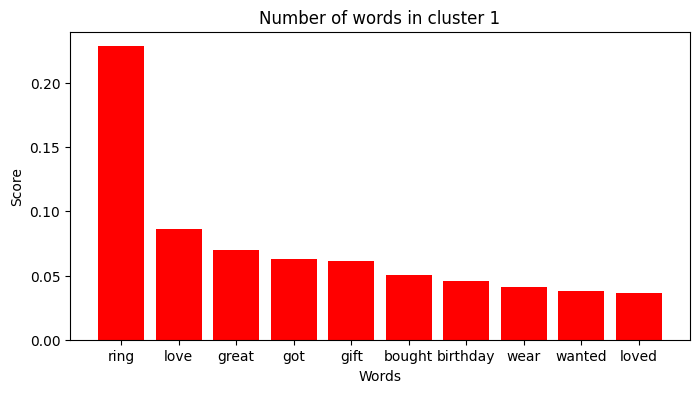

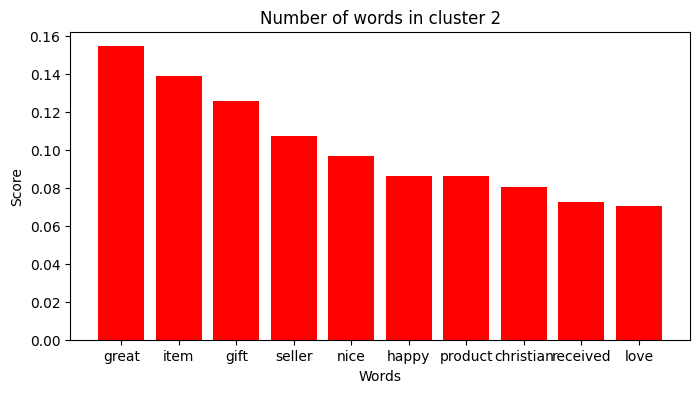

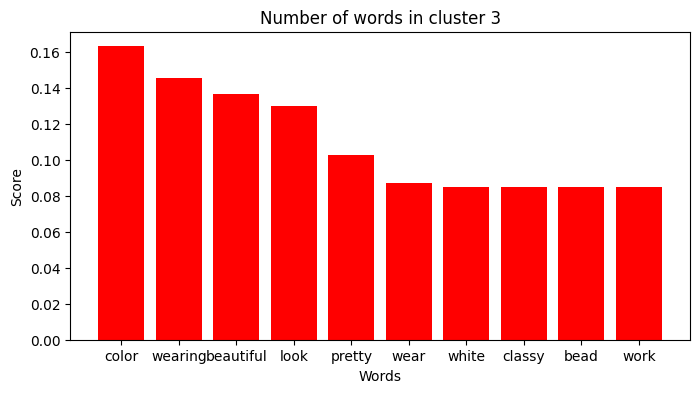

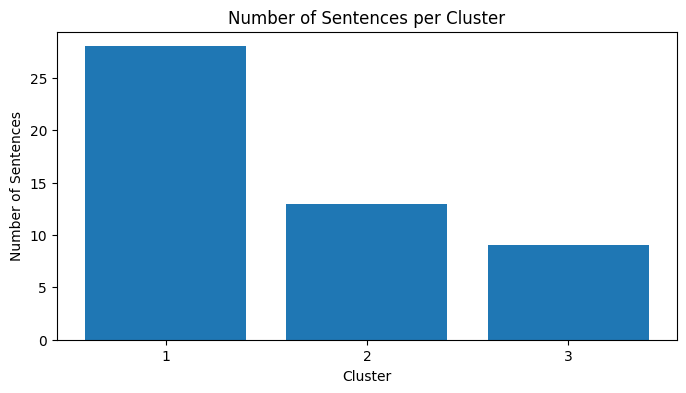

In [64]:
display(allw)

# Task 5 (Text Summarization)

This code below gets the reviews for each cluster created in Section 2 (Optimized model), converts back to raw text and combines the sentences ready for summarisation. Make sure to run the 'Optimized Model' code in Task 4 before running this cell

In [81]:
all_sentences = []

# hard code optimal clusters for testing
optimal_clusters = 2

# Initialize a dictionary to store document IDs for each cluster
cluster_documents = {cluster_id: [] for cluster_id in range(optimal_clusters)}

# Populate the cluster_documents dictionary with document IDs
for doc_id, cluster_id in enumerate(topics):
    cluster_documents[cluster_id].append(doc_id)

# Print the sentences for each document in each cluster
for cluster_id, documents in cluster_documents.items():

    sentences_in_cluster = []
    for doc_id in documents:
        # Adjust document ID to match one-indexing
        doc_id += 1

        clean = all_reviews[doc_id - 1]  # Adjust index for zero-indexing
        sentence = clean_data_to_raw.get(clean, None)
        sentences_in_cluster.append(sentence)

    print(len((sentences_in_cluster)))
    cleaned = ' '.join(sentences_in_cluster)
    all_sentences.append(cleaned)

#print to view clustered reviews
#all_sentences

25
25


##  5A & 5B  - Abstraction 1

In [67]:
from transformers import BartTokenizer, PegasusTokenizer
from transformers import BartForConditionalGeneration, PegasusForConditionalGeneration

IS_CNNDM = True # whether to use CNNDM dataset (BART-base) or XSum dataset (PEGASUS-base)
LOWER = False

# Load our model checkpoints
if IS_CNNDM:
    brio_model = BartForConditionalGeneration.from_pretrained('Yale-LILY/brio-cnndm-uncased')
    brio_tokenizer = BartTokenizer.from_pretrained('Yale-LILY/brio-cnndm-uncased')
else:
    brio_model = PegasusForConditionalGeneration.from_pretrained('Yale-LILY/brio-xsum-cased')
    brio_tokenizer = PegasusTokenizer.from_pretrained('Yale-LILY/brio-xsum-cased')


config.json:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

The following code use the pre-trained model 'Brio' to generate summaries for the 2 clusters. A title is also generated by using summary as the input and creating another summary from this.

In [69]:

max_length = 100
title_length = 10

brio_summaries = []
for sentences in all_sentences:

    # Tokenize the text
    input_ids = brio_tokenizer.encode(sentences[:1024], return_tensors='pt')
    # Generate summary with the model
    summary_ids = brio_model.generate(input_ids, max_length=max_length)
    # Decode the summary
    summary = brio_tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    brio_summaries.append(summary)

    # Generate title from summary
    title_ids = brio_model.generate(summary_ids, max_length=title_length)
    title = brio_tokenizer.decode(title_ids[0], skip_special_tokens=True)

    print("Title: {}".format(title))
    print("Summary:")
    print(summary)

    print('-' * 100)




Title: first shipment of this ring had scratches
Summary:
first shipment of this ring had scratches on the diamond and was missing 2 diamonds on the shoulder of the ring. this ring is beyond gorgeous, I just love it. I bought this ring as a Valentine's gift but couldn't give it to my husband because it spins.
----------------------------------------------------------------------------------------------------
Title: spend your money on a higher
Summary:
spend your money on a higher quality item. the Holy Land Sand is present in a compartment on the rosary. one of the jewels fell out of the wing and the metal is already tarnishing. the bioplast helps lessen the appitite but your ears are sore after wearing.
----------------------------------------------------------------------------------------------------


##  5A & 5B - Abstraction 2

In [70]:
# install

%cd /content/
!git clone https://github.com/abertsch72/unlimiformer.git
!pip install -q -r unlimiformer/requirements.txt
!pip install -q faiss-cpu
%cd unlimiformer/src

from unlimiformer import Unlimiformer
from random_training_unlimiformer import RandomTrainingUnlimiformer
from usage import UnlimiformerArguments, training_addin

from transformers import BartForConditionalGeneration, AutoTokenizer
from datasets import load_dataset
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# example using govreport
modelname = "abertsch/unlimiformer-bart-govreport-alternating"

unlimiformer_tokenizer = AutoTokenizer.from_pretrained("facebook/bart-base")
unlimiformer_model = BartForConditionalGeneration.from_pretrained(modelname)

defaults = UnlimiformerArguments()
unlimiformer_kwargs = {
            'layer_begin': defaults.layer_begin,
            'layer_end': defaults.layer_end,
            'unlimiformer_head_num': defaults.unlimiformer_head_num,
            'exclude_attention': defaults.unlimiformer_exclude,
            'chunk_overlap': defaults.unlimiformer_chunk_overlap,
            'model_encoder_max_len': defaults.unlimiformer_chunk_size,
            'verbose': defaults.unlimiformer_verbose, 'tokenizer': unlimiformer_tokenizer,
            'unlimiformer_training': defaults.unlimiformer_training,
            'use_datastore': defaults.use_datastore,
            'flat_index': defaults.flat_index,
            'test_datastore': defaults.test_datastore,
            'reconstruct_embeddings': defaults.reconstruct_embeddings,
            'gpu_datastore': defaults.gpu_datastore,
            'gpu_index': defaults.gpu_index
}

unlimiformer_model.to(device)

unlimiformer_model = Unlimiformer.convert_model(unlimiformer_model, **unlimiformer_kwargs)
unlimiformer_model.eval()
unlimiformer_model.to(device)

clear_output()

In [71]:

max_length = 100
title_length = 10

unilimiformer_summaries = []

for sentences in all_sentences:

  # Tokenize the text
  input_ids = unlimiformer_tokenizer.encode(sentences[:1024], return_tensors='pt')
  # Generate summary with the model
  summary_ids = unlimiformer_model.generate(input_ids, max_length=max_length)
  # Decode the summary
  summary = unlimiformer_tokenizer.decode(summary_ids[0], skip_special_tokens=True)
  unilimiformer_summaries.append(summary)

  # title
  title_ids = unlimiformer_tokenizer.encode(summary, return_tensors='pt')
  title_ids = unlimiformer_model.generate(input_ids, max_length=title_length)
  title = unlimiformer_tokenizer.decode(title_ids[0], skip_special_tokens=True)


  print("Title: {}".format(title ))
  print("Summmary:")
  print(summary)
  print('-' * 100)


INFO:Unlimiformer:Encoding 0 to 225 out of 225
INFO:Unlimiformer:Encoding 0 to 225 out of 225
INFO:Unlimiformer:Encoding 0 to 232 out of 232


Title: This ring is a beautiful ring but
Summmary:
This ring is a beautiful ring but the first shipment of this ring had scratches on the diamond and was missing 2 diamonds on the shoulder of the ring. I received this ring for a replacement of the same ring, the second ring was even worse. Clearly visible white scratch right in the middle of a black diamond does not look that great. I also bought this ring as a Valentine's gift but could not give it since the hands holding the symbol would reverse whenever the ring spins. It is
----------------------------------------------------------------------------------------------------


INFO:Unlimiformer:Encoding 0 to 232 out of 232


Title: Why GAO Did This Study

Summmary:
Why GAO Did This Study

This testimony discusses GAO's decision to purchase an piercing of mine which was not mentioned in the description. The jewels fell out of the wing and one of the jewels fell from the wing. GAO could see the quality work in this rosary. There was only one thing buyers need to be aware of when buying this item that wasn't mentioned in description, the Holy Land Sand is present in a compartment on the rosaries. GA
----------------------------------------------------------------------------------------------------


## 5A & 5B - Extraction 1

In [72]:
# install model
%cd /content/
!pip install -q bert-extractive-summarizer
from summarizer import Summarizer

bertsum_model = Summarizer()


/content


config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [76]:
# function to create title for extraction models using Brio

def generate_title(summary):

    title_length = 10
    # Generate title from summary
    title_ids = brio_model.generate(summary_ids, max_length=title_length)
    title = brio_tokenizer.decode(title_ids[0], skip_special_tokens=True)

    return title

For creating titles using an extracton method, this wasnt possible as you can only determine number of sentences you want rather than the length of the title, so when using an extraction method for this, the titles was way too long. The solution to this was by using an abstaction method as shown in the function above to create the titles

In [77]:
bertsum_summaries = []

for sentences in all_sentences:

  # create summary for each cluster
  summary = bertsum_model(sentences[:1024], num_sentences=10)
  bertsum_summaries.append(summary)

  # generate title for summary using brio
  title = generate_title(summary)

  print("Title: {}".format(title))
  print("Summary:")
  print(summary)
  print('-' * 100)


Title: GAO purchased a rosary
Summary:
This ring is a beautiful ring but the first shipment of this ring had scratches on the diamond and was missing 2 diamonds on the shoulder of the ring. I returned the ring for a replacement of the same ring, the second ring was even worse. Clearly visible white scratch right in the middle of a black diamond does not look that great. And this time 1 diamond missing on the shoulder of the ring. I wanted to know if this ring is like 2 rings in one, because this ring is beyond gorgeous, I just love it. I got this ring for my birthday and I love it, I cannot imagine a woman not adoring this ring. I wear the ring on my index finger and it fits great! I bought this ring as a Valentine's gift but couldn't give it since the hands holding the heart symbol would reverse whenever the ring spins (there are 4 of them on this ring, alternating the facing direction). It's a cute ring so I just kept it for myself.
---------------------------------------------------

## 5A & 5B - Extraction 2

In [78]:
# install model
%cd /content/
!pip install -U -q sentence-transformers
from summarizer.sbert import SBertSummarizer

sbert_model = SBertSummarizer('paraphrase-MiniLM-L6-v2')


/content


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [79]:
j = 1
max_length = 100


sbert_summaries = []

for sentences in all_sentences:

  # create a summary for each cluster
  summary = sbert_model(sentences[:1024], num_sentences=5)
  sbert_summaries.append(summary)

  #generate title using brio
  title = generate_title(summary)

  print("Title: {}".format(title))
  print("Summary:")
  print(summary)
  print('-' * 100)

  j+=1



Title: GAO purchased a rosary
Summary:
This ring is a beautiful ring but the first shipment of this ring had scratches on the diamond and was missing 2 diamonds on the shoulder of the ring. I returned the ring for a replacement of the same ring, the second ring was even worse. Clearly visible white scratch right in the middle of a black diamond does not look that great. I got this ring for my birthday and I love it, I cannot imagine a woman not adoring this ring. I wear the ring on my index finger and it fits great!
----------------------------------------------------------------------------------------------------
Title: GAO purchased a rosary
Summary:
I only had it a week before one of the jewels fell out of the wing. Spend your money on a higher quality item. its what i wanted :) but its not my favorite piercing of mine but i have to wear the bioplast cuz i break out with certain metals They definitely help lessen your appitite, however my ears were sore after wearing for about 3 ho

## 5C -  Evaluation with gpt summary

As can be observed above, the appear summarys perform well and are meangingful however, the titles stuggle to summarise the whole summary. This could be due to the lack of input to the title generator, as the summary itself was used for this. For futuretesting, finding a pre-trained model may be more suited for this task. To evaluate the performance of the model, chatGPT was asked to summarise the same text for both clusters as a reference. Both the chatGPT summaries and the summaries created from the models were embedded using the Distilbert embedding function in section 3a to gather the semantic meaning of the texts. Cosine similarity is then used between the two in order to gather the similary between the texts

In [82]:

#GPT summaries
summary1 = "The ring initially received had scratches and missing diamonds. A replacement was also flawed, prompting a refund. Despite flaws, the ring is adored for its beauty and comfort. Some users found issues with resizing and soft metal. However, many praised its appearance, sparkle, and value, with some considering it two rings in one. It's recommended for its durability, affordability, and suitability as a gift. Users appreciated its design, particularly for lovers of hearts and Claddagh rings. Overall, despite some quality concerns, it's seen as a worthwhile purchase for its aesthetics and value."
summary2 = "The item received mixed reviews, with complaints about jewel quality and metal tarnishing, while others found it satisfactory. Some experienced discomfort with earrings, while a rosary received praise for its craftsmanship and inclusion of Holy Land sand. Buyers appreciated jewelry quality compared to price, considering it a great gift. Birthstone jewelry was well-received, with sentiments of sentimentality and appreciation. Various items, including Celtic pieces and sports-themed jewelry, were praised for their appearance and suitability for occasions. Overall, while some had issues, many found the items beautiful and worth the purchase."


# clean and embed summary 1
clean_gpt_1 = clean_data(summary1)
cleaned_gpt_1 = ' '.join(clean_gpt_1)
gptdocs_1 = pd.Series(cleaned_gpt_1)
embedGPT_1 = embed_data(gptdocs_1)

# clean and embed summary 2
clean_gpt_2 = clean_data(summary2)
cleaned_gpt_2 = ' '.join(clean_gpt_2)
gptdocs_2 = pd.Series(cleaned_gpt_2)
embedGPT_2 = embed_data(gptdocs_2)


In [83]:
#Brio clean and embed
clean_summary_1 = clean_data(brio_summaries[0])
cleaned_summary_1 = ' '.join(clean_summary_1)
clean_docs_1 = pd.Series(cleaned_summary_1)
embeded_data_1 = embed_data(clean_docs_1)


clean_summary_2 = clean_data(brio_summaries[1])
cleaned_summary_2 = ' '.join(clean_summary_1)
clean_docs_2 = pd.Series(cleaned_summary_2)
embeded_data_2 = embed_data(clean_docs_2)

#Unilimiformer clean and embed
clean_summary_3 = clean_data(unilimiformer_summaries[0])
cleaned_summary_3 = ' '.join(clean_summary_3)
clean_docs_3 = pd.Series(cleaned_summary_3)
embeded_data_3 = embed_data(clean_docs_3)

clean_summary_4 = clean_data(unilimiformer_summaries[1])
cleaned_summary_4 = ' '.join(clean_summary_4)
clean_docs_4 = pd.Series(cleaned_summary_4)
embeded_data_4 = embed_data(clean_docs_4)

#Bertsum clean and embed
clean_summary_5 = clean_data(bertsum_summaries[0])
cleaned_summary_5 = ' '.join(clean_summary_5)
clean_docs_5 = pd.Series(cleaned_summary_5)
embeded_data_5 = embed_data(clean_docs_5)


clean_summary_6 = clean_data(bertsum_summaries[1])
cleaned_summary_6 = ' '.join(clean_summary_6)
clean_docs_6 = pd.Series(cleaned_summary_6)
embeded_data_6 = embed_data(clean_docs_6)

#SBert clean and embed

clean_summary_7 = clean_data(sbert_summaries[0])
cleaned_summary_7 = ' '.join(clean_summary_7)
clean_docs_7 = pd.Series(cleaned_summary_7)
embeded_data_7 = embed_data(clean_docs_7)

clean_summary_8 = clean_data(sbert_summaries[1])
cleaned_summary_8 = ' '.join(clean_summary_8)
clean_docs_8 = pd.Series(cleaned_summary_8)
embeded_data_8 = embed_data(clean_docs_8)


In [84]:
# calculate the cosine similarity's for the GPT summaries and generated summaries

# Brio

similarities_1 = cosine_similarity(embeded_data_1, embedGPT_1)
similarities_2 = cosine_similarity(embeded_data_2, embedGPT_2)

#Uni
similarities_3 = cosine_similarity(embeded_data_3, embedGPT_1)
similarities_4 = cosine_similarity(embeded_data_4, embedGPT_2)

#BertSum

similarities_5 = cosine_similarity(embeded_data_5, embedGPT_1)
similarities_6 = cosine_similarity(embeded_data_6 , embedGPT_2)

#Sbert

similarities_7 = cosine_similarity(embeded_data_7, embedGPT_1)
similarities_8 = cosine_similarity(embeded_data_8 , embedGPT_2)

In [85]:
# Get the data out of the list for better viewing purposes

#Brio

similarities_1 = similarities_1[0][0]
similarities_2 = similarities_2[0][0]

print(similarities_1)
print(similarities_2)

#Uni
similarities_3 = similarities_3[0][0]
similarities_4 = similarities_4[0][0]

print(similarities_3)
print(similarities_4)


#Bertsum

similarities_5 = similarities_5[0][0]
similarities_6 = similarities_6[0][0]

print(similarities_5)
print(similarities_6)


#SBert

similarities_7 = similarities_7[0][0]
similarities_8 = similarities_8[0][0]

print(similarities_7)
print(similarities_8 )

0.8654574
0.84637165
0.8390846
0.92341083
0.8758114
0.92741686
0.8898261
0.9093284


In [86]:
# Create DataFrame and show the results
sim = {
    'Abstract - Brio, Cluster 1': [similarities_1],
    'Abstract - Brio, Cluster 2': [similarities_2],
    'Abstract - Unilimiformer, Cluster 1': [similarities_3],
    'Abstract - Unilimiformer, Cluster 2': [similarities_4],
    'Extract - Bertsum, Cluster 1': [similarities_5],
    'Extract - Bertsum, Cluster 2': [similarities_6],
    'Extract - SBert, Cluster 1': [similarities_7],
    'Extract - SBert, Cluster 2': [similarities_8]
}

df = pd.DataFrame(sim)

df

,"Abstract - Brio, Cluster 1","Abstract - Brio, Cluster 2","Abstract - Unilimiformer, Cluster 1","Abstract - Unilimiformer, Cluster 2","Extract - Bertsum, Cluster 1","Extract - Bertsum, Cluster 2","Extract - SBert, Cluster 1","Extract - SBert, Cluster 2"
0,0.865457,0.846372,0.839085,0.923411,0.875811,0.927417,0.889826,0.909328


In [87]:


# Calculate average similarities for each group
BrioAverage = np.mean([similarities_1, similarities_2])
UnilimiformerAverage = np.mean([similarities_3, similarities_4])
BertSumAverage = np.mean([similarities_5, similarities_6])
SBertAverage = np.mean([similarities_7, similarities_8])

# Print average similarities for each group
print("Brio Average:", BrioAverage)
print("Unilimiformer Average:", UnilimiformerAverage)
print("BertSum Average:", BertSumAverage)
print("SBert Average:", SBertAverage)
print("_"* 100)

# Calculate standard deviation for each group
BrioStd = np.std([similarities_1, similarities_2])
UnilimiformerStd = np.std([similarities_3, similarities_4])
BertSumStd = np.std([similarities_5, similarities_6])
SBertStd = np.std([similarities_7, similarities_8])

# Print standard deviation for each group
print("Brio Standard Deviation:", BrioStd)
print("Unilimiformer Standard Deviation:", UnilimiformerStd)
print("BertSum Standard Deviation:", BertSumStd)
print("SBert Standard Deviation:", SBertStd)

# Calculate overall average similarities for abstract and extractive methods
AbstractAverage = np.mean([similarities_1, similarities_2, similarities_3, similarities_4])
ExtractiveAverage = np.mean([similarities_5, similarities_6, similarities_7, similarities_8])

# Print overall average similarities for abstract and extractive methods
print("-" * 100)
print("Abstractive method overall average:", AbstractAverage)
print("Extractive method overall average:", ExtractiveAverage)


Brio Average: 0.85591453
Unilimiformer Average: 0.88124776
BertSum Average: 0.9016141
SBert Average: 0.89957726
____________________________________________________________________________________________________
Brio Standard Deviation: 0.009542882
Unilimiformer Standard Deviation: 0.042163104
BertSum Standard Deviation: 0.025802732
SBert Standard Deviation: 0.009751141
----------------------------------------------------------------------------------------------------
Abstractive method overall average: 0.8685812
Extractive method overall average: 0.9005957


As can be observed above, the extractive methods work slightly better than the abstractive methods however, both methods perform well with high accuracy. From the two abstactive methods, Unilimiformer performs slightly better than Brio. For extractive, Bertsum performed better than SBert.

## 5D & 5E - Interactive UI

This interactive method combines the LSI, Bert topic modelling and summarisation. The user can type in a query, choose the number of documents to retrieve, cluster using either a set amount of clusters or allow the algorithm to optimize using the silouhette method from a dropdown box, and then the user has a choice of summarising with either an abstractive method (unilimiformer) or an extractive method (bertsum). The result shows the list of raw reviews and summary for each cluster. Note that the unilimiformer takes a little while to produce the summaries. For the additional feature as required for question 5d, a feature has been added to this section. This feature allows the user to group the reviews by their rating rather than using the clustering algorithm.The reviews are displayed in ascending order of rating and a summary of the whole group is displayed. Code was also added to format the printing so that there is a margin and the review/summary width doesnt go past a certain width on the screen.

IMPORTANT - In order to run this code, ensure all the previous code blocks for the models have ran including distilbert, bert topic, abstractive method 2 (unilimiformer), extraction model 1(bertsum) etc.

In [88]:
import ipywidgets as widgets
from sklearn.metrics import silhouette_score
from IPython.display import clear_output
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import textwrap
from bertopic.vectorizers import ClassTfidfTransformer

allw = widgets.Output()

reviews = []

# function to clean and embed query
def process_query(query, vocab, weightScheme):
    query = clean_data(query)
    line = ' '.join(query)
    vectorizer = CountVectorizer(vocabulary=vocab)
    transformer = TfidfTransformer(norm=weightScheme, sublinear_tf= True)
    encoded = transformer.fit_transform(vectorizer.fit_transform([line]))
    return encoded

# function to embed data
def vectorize_data(data, vocab, weightScheme):
    vectorizer = CountVectorizer(vocabulary=vocab)
    transformer = TfidfTransformer(norm= weightScheme, sublinear_tf=True)
    data_transformed = transformer.fit_transform(vectorizer.fit_transform(data))
    return data_transformed

def retrieve_top_docs(query, n):

    all_reviews = []

    # mapping from id to vectorized document
    id_to_vectorized = dict(zip(ids, data_vectorized))

    # Find similarities for each query
    processed_query = process_query(query, vocab, best_norm)

    transformed_query = trunc_SVD_model.transform(processed_query)
    similarities = cosine_similarity(data_vectorized, transformed_query)
    indexes = np.argsort(similarities.flat)[-n:]

    # Retrieve the top n vectorized documents
    top_n_vectorized = data_vectorized[indexes]

    # Map the vectorized documents back to their corresponding IDs
    top_n_ids = [id for id, vectorized in id_to_vectorized.items() if vectorized in top_n_vectorized]

    for id in top_n_ids:
        review = id_to_raw_data.get(id, None)
        cleaned_review = id_to_clean_data.get(id, None)
        all_reviews.append(cleaned_review)

    reviews.append(all_reviews)

    return all_reviews

def embed_model(reviews):

    embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
    embeddings = embedding_model.encode(reviews)

    return embeddings

def group_by_ratings(reviews, cluster_model):
    # dictionary to store reviews grouped by ratings
    reviews_by_ratings = {}

    for review in reviews:
        # First convert the clean data back to raw
        raw_data = clean_data_to_raw.get(review)

        # Retrieve the rating for the raw data
        rating = id_to_rating.get(raw_data, "None")

        # Add the review to the corresponding rating group
        if rating not in reviews_by_ratings:
            reviews_by_ratings[rating] = [raw_data]
        else:
            reviews_by_ratings[rating].append(raw_data)

    # Sort the ratings in ascending order
    sorted_ratings = sorted(reviews_by_ratings.keys())


    # Print reviews grouped by ratings in ascending order
    for rating in sorted_ratings:
        print("\nRating:", rating)
        all_reviews_in_rating_cluster = []
        s =1
        for review in reviews_by_ratings[rating]:
            all_reviews_in_rating_cluster.append(review)
            # set the width of the review
            wrapped_review_data = textwrap.fill(review, width=100, subsequent_indent="    ")
            print(s, "|",wrapped_review_data)
            s+=1

        # join the reviews into one sentence
        all_reviews_joined = ' '.join(all_reviews_in_rating_cluster)
        summary = summarise_cluster(all_reviews_joined, cluster_model)

        print("\nSummary of rating group:")
        # set the width of summary
        wrapped_summary = textwrap.fill(summary, width=100)
        print(wrapped_summary)

        print("-" * 100)


    return reviews_by_ratings



def optimize_clustering(reviews):

    print("Finding optimal number of clusters.. ")
    embeddings = embed_model(reviews)
    # Define the valid range for the number of clusters
    n_samples = len(reviews)
    valid_range_n_clusters = list(range(2, min(n_samples, 8) + 1))

    # Initialize a list to store silhouette scores
    silhouette_avg = []

    # Iterate over different cluster numbers in the valid range
    for num_clusters in valid_range_n_clusters:
        # Initialize KMeans model
        kmeans = KMeans(n_clusters=num_clusters)
        kmeans.fit(embeddings)

        # Get cluster labels
        cluster_labels = kmeans.labels_

        # Calculate silhouette score
        silhouette_avg.append(silhouette_score(embeddings, cluster_labels))

    # Find the optimal number of clusters (highest silhouette score)
    optimal_clusters = valid_range_n_clusters[silhouette_avg.index(max(silhouette_avg))]

    return optimal_clusters

def summarise_cluster(sentences, cluster_model):

  max_length = 100

  # user has choice of either extractive or abstractive
  if cluster_model == 'Extractive':


    summary = bertsum_model(sentences[:1024], num_sentences=10)

  if cluster_model == 'Abstractive':

    # Tokenize the text
    input_ids = unlimiformer_tokenizer.encode(sentences[:1024], return_tensors='pt')
    # Generate summary with the model
    summary_ids = unlimiformer_model.generate(input_ids, max_length=max_length)
    # Decode the summary
    summary = unlimiformer_tokenizer.decode(summary_ids[0], skip_special_tokens=True)

  return summary

def clustering(reviews, n_clusters):

    # Step 1 - Extract embeddings
    embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

    # Step 2 - Reduce dimensionality
    if RedDiMethod == 'SVD':
        RD_model = TruncatedSVD(n_components=50)
    elif RedDiMethod == 'PCA':
        RD_model = PCA(n_components='mle')
    else:
        RD_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine')

    # Step 3 - Cluster reduced embeddings
    Cluster_model = KMeans(n_clusters=n_clusters, random_state=42)

    # Step 4 - Tokenize topics
    vectorizer_model = CountVectorizer(stop_words="english")

    # Step 5 - Create topic representation
    ctfidf_model = ClassTfidfTransformer()

    # All steps together
    topic_model = BERTopic(
        embedding_model=embedding_model,  # Step 1 - Extract embeddings
        umap_model=RD_model,  # Step 2 - Reduce dimensionality
        hdbscan_model=Cluster_model,  # Step 3 - Cluster reduced embeddings
        vectorizer_model=vectorizer_model,  # Step 4 - Tokenize topics
        ctfidf_model=ctfidf_model,  # Step 5 - Extract topic words
        calculate_probabilities=True
    )

    topics, probs = topic_model.fit_transform(reviews)

    return topics

def perform_processing(reviews, num_of_clusters, cluster_model):

    # if statements on number of clusters depending on user input
    if (num_of_clusters) == '2':
        n_clusters = 2
    elif (num_of_clusters) == '3':
        n_clusters = 3
    elif (num_of_clusters) == '4':
        n_clusters = 4
    elif (num_of_clusters) == '5':
        n_clusters = 5
    elif num_of_clusters == 'Optimize':
        n_clusters = optimize_clustering(reviews)

    print("Number of clusters", n_clusters)

    topics = clustering(reviews, n_clusters)

    topic_info = topic_model.get_topic_info()

    # Get the document IDs for each cluster
    cluster_documents = {cluster_id: [] for cluster_id in range(n_clusters)}

    for doc_id, cluster_id in enumerate(topics):
        cluster_documents[cluster_id].append(doc_id)

    number_of_sentences_per_cluster = []

    # Print the sentences for each document in each cluster
    for cluster_id, documents in cluster_documents.items():

        print(f"\nCluster {cluster_id + 1}")
        s = 1

        all_sentences_per_cluster = []


        for doc_id in documents:
            # Convert from clean data to raw for printing and summarization
            rev = reviews[doc_id]
            raw_data = clean_data_to_raw.get(rev, None)

            # Set width of review
            wrapped_raw_data = textwrap.fill(raw_data, width=100, subsequent_indent="    ")

            print(s, "|", wrapped_raw_data)

            all_sentences_per_cluster.append(raw_data)
            s += 1


        # apply summarisation
        sentences = ' '.join(all_sentences_per_cluster)
        summary = summarise_cluster(sentences, cluster_model)
        print("\nSummary of cluster:")
        # set width of summary
        wrapped_summary = textwrap.fill(summary, width=100)
        print(wrapped_summary)

        print("-" * 100)

        num_of_sent = (s - 1)
        number_of_sentences_per_cluster.append(num_of_sent)

    return


def process(_):

  clear_output(wait=True)
  display(allw)
  query = query_field.value
  n = n_doc_field.value
  num_of_clusters = cluster_dropdown.value
  cluster_model = cluster_model_dropdown.value
  is_ratings = ratings_checkbox.value


  # Check if query or n is empty
  if not query or not n:
      print("Please enter both a query and a value for the number of documents.")
      return
  try:
      n = int(n)
      if n <= 0:
          print("Please enter a valid positive value for the number of documents.")
          return
  except ValueError:
      print("Please enter a valid numeric value for the number of documents.")
      return

  #get top docuemnts
  reviews = retrieve_top_docs(query, n)

  # group by ratings
  if is_ratings == True:

    group_by_ratings(reviews, cluster_model)

  # apply clustering
  else:
    perform_processing(reviews, num_of_clusters, cluster_model)

  return


# SVD on data
data_transformed = vectorize_data(data, vocab, best_norm)
trunc_SVD_model = TruncatedSVD(n_components=best_n_comp)
data_vectorized = trunc_SVD_model.fit_transform(data_transformed)

In [89]:
# Search button
search_button = widgets.Button(description="Search")
search_button.on_click(process)

# number of clusters dropdown
cluster_options = ['2', '3', '4', '5', 'Optimize']
cluster_dropdown = widgets.Dropdown(options=cluster_options, description='Num of Clusters:')

# cluster model

cluster_model_options = ['Abstractive', 'Extractive']
cluster_model_dropdown = widgets.Dropdown(options=cluster_model_options, description='Cluster Model:')

# query field
query_field = widgets.Text(description="Enter Query:")
n_doc_field = widgets.Text(description="Enter the number of related documents you wish to retrieve:")

# rating checkbox

# Create a checkbox widget
ratings_checkbox = widgets.Checkbox(
    value=False,
    description='Group by Ratings',
    disabled=False
)

#H layout
query_fields = widgets.HBox([query_field, n_doc_field])
cluster_fields = widgets.HBox([cluster_dropdown, cluster_model_dropdown])

output = widgets.Output()

allw = widgets.VBox([query_fields, cluster_fields,ratings_checkbox, search_button, output])

In [90]:
display(allw)

Finding optimal number of clusters.. 
Number of clusters 3

Cluster 1
1 | my only wish on this ring is- I wish the cut potrion went all the way around the ring. Other than
    that a great very comfortable ring.
2 | This ring is exactly what I wanted, I actually bought another and it wasn't quite as solidly made as
    this ring is. Thanks for the great ring!
3 | Great ring! I tried a different one first but the individual rings were so thin that they snapped
    within a few weeks. The rings on this one are thicker, making it a bolder and more durable ring.
    Of course it costs a bit more but you can't go wrong paying for better quality!
4 | I got the ring as a promise ring for my girlfriend for Christmas and she loved it. Definitely a
    great value.
5 | my wife loves the ring, it was a great gift. extremelly cheap and high quality.
6 | This ring has such a good sparkle and it looks like a ring that should cost 10x the amount. Makes a
    great gift for someone on a budget. My gir

# Code to convert to PDF

In [17]:
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc

clear_output()

In [18]:
!jupyter nbconvert --to pdf <'/content/drive/MyDrive/Colab Notebooks/George_Brown_F328685_NLP_CW.ipynb.ipynb'>.ipynb

/bin/bash: line 1: /content/drive/MyDrive/Colab Notebooks/George_Brown_F328685_NLP_CW.ipynb.ipynb: No such file or directory


In [19]:
from google.colab import files
import os

# Define the notebook path
notebook_path = '/content/drive/MyDrive/Colab Notebooks/George_Brown_F328685_NLP_CW.ipynb'

# Define the output directory
output_dir = '/content/'

# Convert the notebook to PDF
!jupyter nbconvert --to pdf "$notebook_path" --output-dir="$output_dir"

# Define the path to the PDF file
pdf_file_path = '/content/George_Brown_F328685_NLP_CW.pdf'

# Check if the PDF file exists
if os.path.exists(pdf_file_path):
    # Download the PDF file
    files.download(pdf_file_path)
else:
    print("PDF file not found.")


[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/George_Brown_F328685_NLP_CW.ipynb to pdf
/usr/local/lib/python3.10/dist-packages/nbconvert/filters/datatypefilter.py:41: UserWarning: Your element with mimetype(s) dict_keys(['text/html']) is not able to be represented.
  warn(
/usr/local/lib/python3.10/dist-packages/nbconvert/filters/datatypefilter.py:41: UserWarning: Your element with mimetype(s) dict_keys(['text/html']) is not able to be represented.
  warn(
[NbConvertApp] Support files will be in George_Brown_F328685_NLP_CW_files/
[NbConvertApp] Making directory ./George_Brown_F328685_NLP_CW_files
[NbConvertApp] Making directory ./George_Brown_F328685_NLP_CW_files
[NbConvertApp] Making directory ./George_Brown_F328685_NLP_CW_files
[NbConvertApp] Making directory ./George_Brown_F328685_NLP_CW_files
[NbConvertApp] Making directory ./George_Brown_F328685_NLP_CW_files
[NbConvertApp] Making directory ./George_Brown_F328685_NLP_CW_files
[NbConvertApp] Making direct